In [1]:
from typing import *
from pathlib import Path
from tqdm import tqdm


import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")
np.random.seed(42)


ROOT_DIR = Path(os.getcwd()).parent.parent

In [2]:
df: pd.DataFrame = pd.read_parquet(os.path.join(ROOT_DIR, "data/datasets/train_17_08_top100_removed.parquet"))

df = df.reset_index(drop=True)
# Create pump hash and convert pump time to datetime
df["pump_hash"] = df["pumped_ticker"] + "_" + df["pump_time"]
df["pump_time"] = pd.to_datetime(df["pump_time"])


df["is_pumped"].value_counts()

is_pumped
False    94040
True       470
Name: count, dtype: int64

In [3]:
drop_groups: List[str] = [
    "linear_liquidity_slope",
    "has_slippage_slope",
    "has_slippage_intercept",
]

cols: List[str] = [col for col in df.columns if all([group not in col for group in drop_groups])]
df: pd.DataFrame = df[cols].copy()

df.head(3)

,overall_return_1h,volume_quote_abs_zscore_1h_30d,num_trades_long_share_1h,volume_quote_long_share_1h,overall_return_6h,volume_quote_abs_zscore_6h_30d,num_trades_long_share_6h,volume_quote_long_share_6h,log_return_std_6h_30d,log_return_zscore_6h_30d,...,quote_abs_powerlaw_alpha_48h,quote_abs_powerlaw_alpha_60h,num_prev_pumps,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash
0,0.939375,-0.231085,0.428571,0.051310,1.056728,0.197912,0.531876,0.482727,1.582570,0.282364,...,1.219476,1.211978,0,binance,AAPCBTC,2020-11-18 18:00:11,DOGEBTC,False,502,AAPCBTC_2020-11-18 18:00:11
1,0.979797,-0.332760,0.400000,0.389846,1.020203,0.047852,0.536000,0.643412,0.871953,0.195838,...,1.257454,1.259982,0,binance,AAPCBTC,2020-11-18 18:00:11,OSTBTC,False,1065,AAPCBTC_2020-11-18 18:00:11
2,1.010388,1.183349,0.484581,0.648486,1.007790,0.446360,0.511811,0.527660,0.950087,0.166672,...,1.200525,1.199585,0,binance,AAPCBTC,2020-11-18 18:00:11,ZRXBTC,False,1162,AAPCBTC_2020-11-18 18:00:11


Replace infs to nans

In [4]:
df = df.replace([np.inf, -np.inf], np.nan)

df.isna().sum().sort_values(ascending=False).head(10)

quote_slippage_imbalance_ratio_1h     6976
quote_slippage_imbalance_ratio_3h     2241
quote_slippage_imbalance_ratio_6h     1071
quote_slippage_imbalance_ratio_12h     507
log_return_std_6h_30d                  337
log_return_zscore_6h_30d               323
quote_abs_powerlaw_alpha_1h            208
quote_slippage_imbalance_ratio_24h     194
num_trades_long_share_1h                86
volume_quote_long_share_1h              86
dtype: int64

In [5]:
reg_cols: List[str] = df.columns[:-7].tolist()
num_cols: List[str] = df.columns[:-8].tolist()

len(reg_cols)

69

<h4>Check how many missing values we have</h4>

In [6]:
df.isna().sum().sort_values()

overall_return_1h                        0
is_pumped                                0
ticker                                   0
pump_time                                0
pumped_ticker                            0
                                      ... 
log_return_std_6h_30d                  337
quote_slippage_imbalance_ratio_12h     507
quote_slippage_imbalance_ratio_6h     1071
quote_slippage_imbalance_ratio_3h     2241
quote_slippage_imbalance_ratio_1h     6976
Length: 76, dtype: int64

<h4>Remove all crosssections without pump observations and pumps with nans </h4>

In [7]:
df_pumps: pd.DataFrame = pd.DataFrame()

for pump_hash, df_pump in tqdm(df.groupby("pump_hash")):
    # check if each crosssection contains only 1 pumped ticker and pumped ticker has no missing values across all columns
    if (df_pump["is_pumped"].sum() == 1) and all(df_pump[df_pump["is_pumped"]].notna().all()):

        for col in reg_cols: # fill nans with median
            col_median: float = df_pump[col].median()
            df_pump[col] = df_pump[col].fillna(col_median)

        df_pumps: pd.DataFrame = pd.concat([df_pumps, df_pump])


df_pumps["is_pumped"].value_counts()

100%|██████████| 498/498 [00:06<00:00, 75.00it/s]


is_pumped
False    83739
True       448
Name: count, dtype: int64

<h4>Describe cols</h4>

In [8]:
df_pumps[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
overall_return_1h,84187.0,1.000273,0.022281,0.564881,0.993355,1.000000,1.006260,1.518794
volume_quote_abs_zscore_1h_30d,84187.0,0.463980,5.869643,-2.873579,-0.506999,-0.237862,0.372828,877.536349
num_trades_long_share_1h,84187.0,0.517576,0.150239,0.000000,0.433333,0.517857,0.604399,1.000000
volume_quote_long_share_1h,84187.0,0.476071,0.206599,0.000000,0.343081,0.477353,0.604102,1.000000
overall_return_6h,84187.0,1.000559,0.040605,-0.058016,0.983654,0.998718,1.013702,2.245771
...,...,...,...,...,...,...,...,...
quote_abs_powerlaw_alpha_6h,84187.0,1.218103,0.091743,1.085779,1.162273,1.204391,1.253110,7.312621
quote_abs_powerlaw_alpha_12h,84187.0,1.204275,0.079069,1.085860,1.154100,1.192029,1.235318,4.958618
quote_abs_powerlaw_alpha_24h,84187.0,1.192125,0.068507,1.084541,1.147511,1.180574,1.220849,4.713602
quote_abs_powerlaw_alpha_48h,84187.0,1.181861,0.061208,1.083779,1.141799,1.171411,1.208814,4.552822


<h4>Remove outliers</h4>

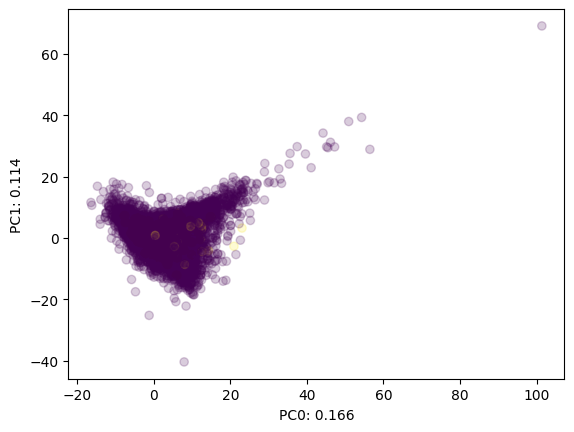

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = StandardScaler().fit_transform(df_pumps[num_cols])

pca = PCA(n_components=X.shape[1])
PCA_proj = pca.fit_transform(X)

plt.scatter(
    PCA_proj[:, 0], PCA_proj[:, 1], c=df_pumps["is_pumped"], alpha=.2
)

plt.xlabel(f"PC0: {pca.explained_variance_ratio_[0]:.3f}")
plt.ylabel(f"PC1: {pca.explained_variance_ratio_[1]:.3f}")


plt.show()

In [10]:
outlier_mask = df_pumps[num_cols] <= df_pumps[num_cols].quantile(.999)
df_clean = df_pumps[outlier_mask.all(axis=1)].copy()

df_clean["is_pumped"].value_counts()

is_pumped
False    81633
True       437
Name: count, dtype: int64

<h4>Remove crosssections without pumps</h4>

In [11]:
df_filtered: pd.DataFrame = pd.DataFrame()

for pump_hash, df_pump in tqdm(df_clean.groupby("pump_hash")):
    # check if each crosssection contains only 1 pumped ticker and pumped ticker has no missing values across all columns
    if (df_pump["is_pumped"].sum() == 1) and all(df_pump[df_pump["is_pumped"]].notna().all()):
        df_filtered: pd.DataFrame = pd.concat([df_filtered, df_pump])

df_filtered["is_pumped"].value_counts()

100%|██████████| 448/448 [00:02<00:00, 157.91it/s]


is_pumped
False    79507
True       437
Name: count, dtype: int64

<h4>Distribution of regressor variables</h4>

In [12]:
col_groups: List[str] = [
    "overall_return",
    "volume_quote_abs_zscore",
    "volume_quote_long_share",
    "log_return_std",
    "log_return_zscore",
    "quote_slippage_abs_share",
    "quote_imbalance_ratio",
    "quote_slippage_imbalance_ratio",
    "quote_abs_powerlaw_alpha",
    "num_prev_pumps",
]

In [13]:
col_map: Dict[str, List[str]] = {}

for group in col_groups:
    col_map[group] = [col for col in df_pumps.columns if group in col]

In [14]:
def plot_hist_cols(df: pd.DataFrame, col_map: Dict[str, List[str]]):
    for group, cols in tqdm(col_map.items()):
        fig, axs = plt.subplots(
            nrows=int(np.ceil(len(cols) / 4)), ncols=4, figsize=(20, 6)
        )
        axs = axs.flatten()

        for ax, col in tqdm(zip(axs, cols), total=len(cols), leave=False):
            sns.histplot(
                data=df, x=col, legend=False, stat="probability", ax=ax
            )
        fig.tight_layout()
        fig.show()

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


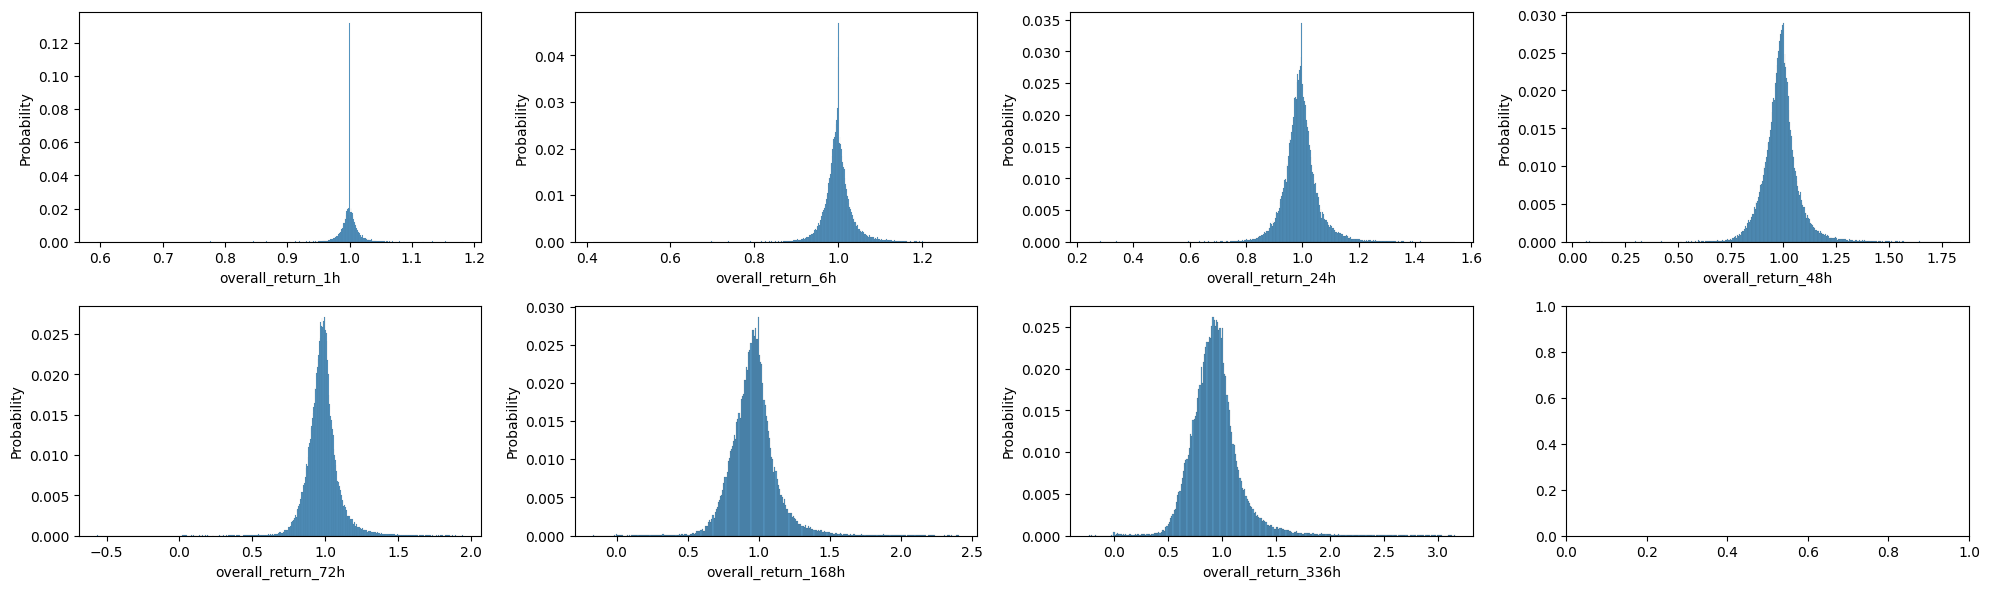

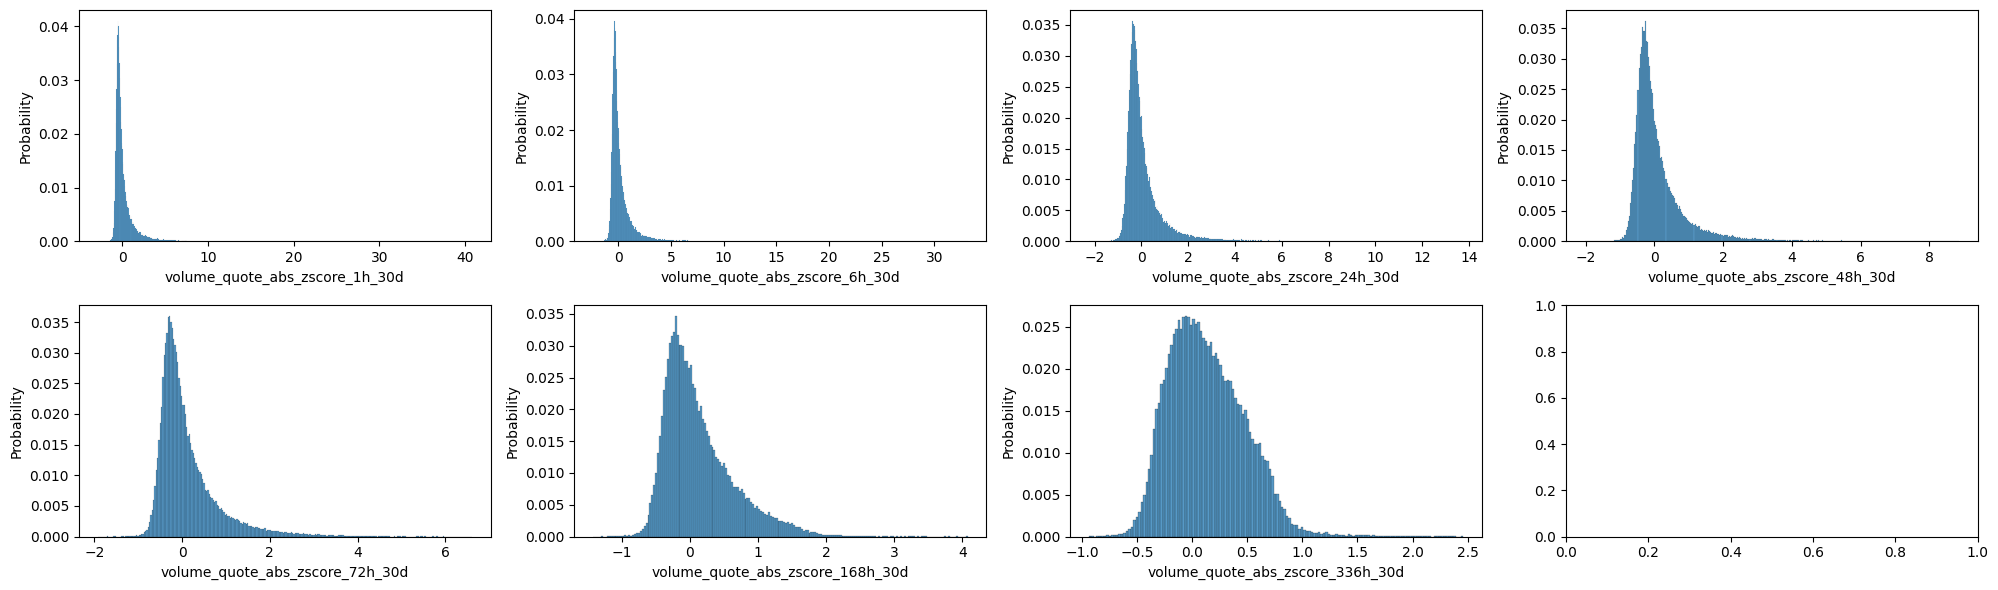

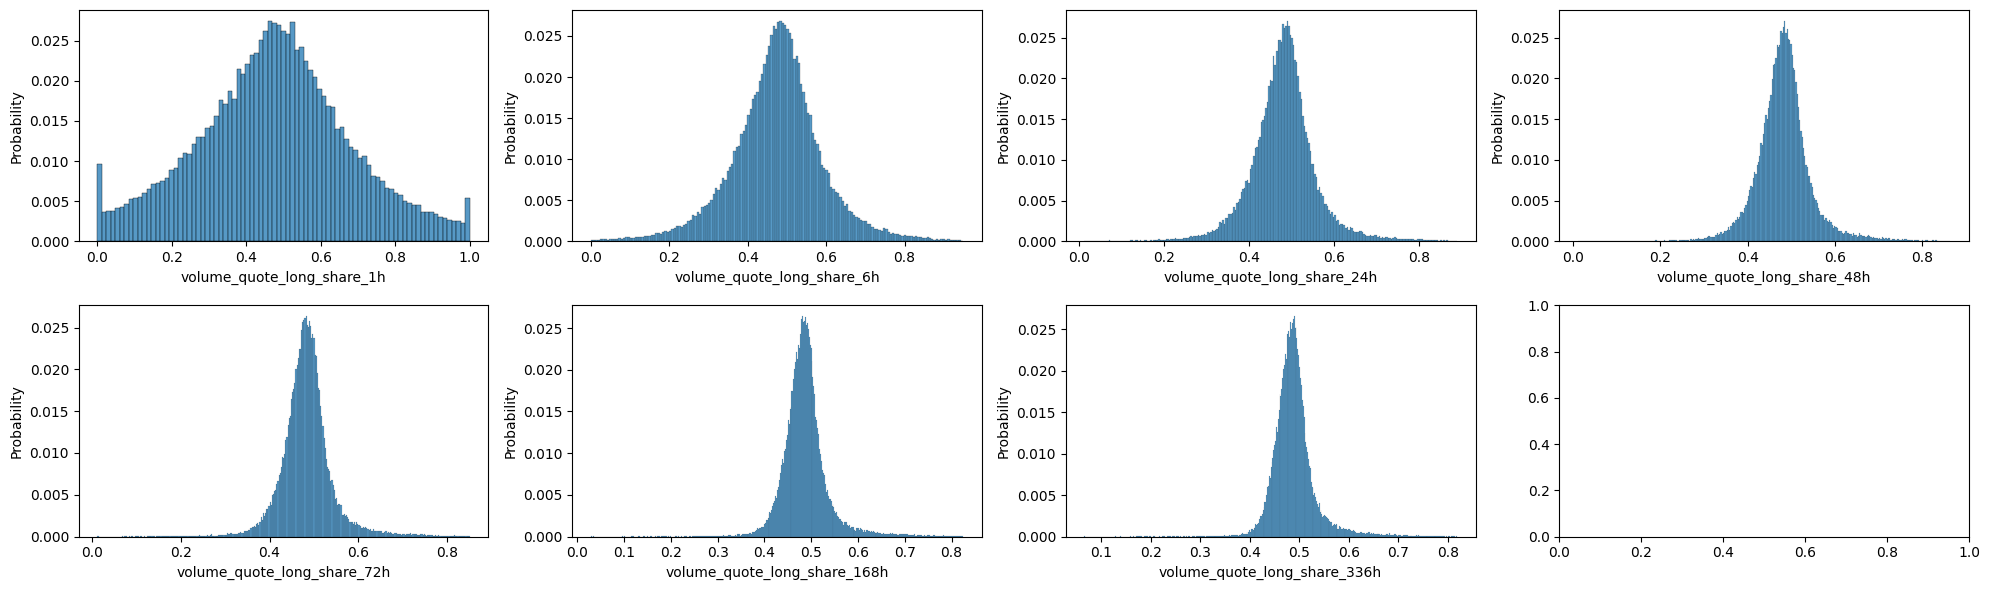

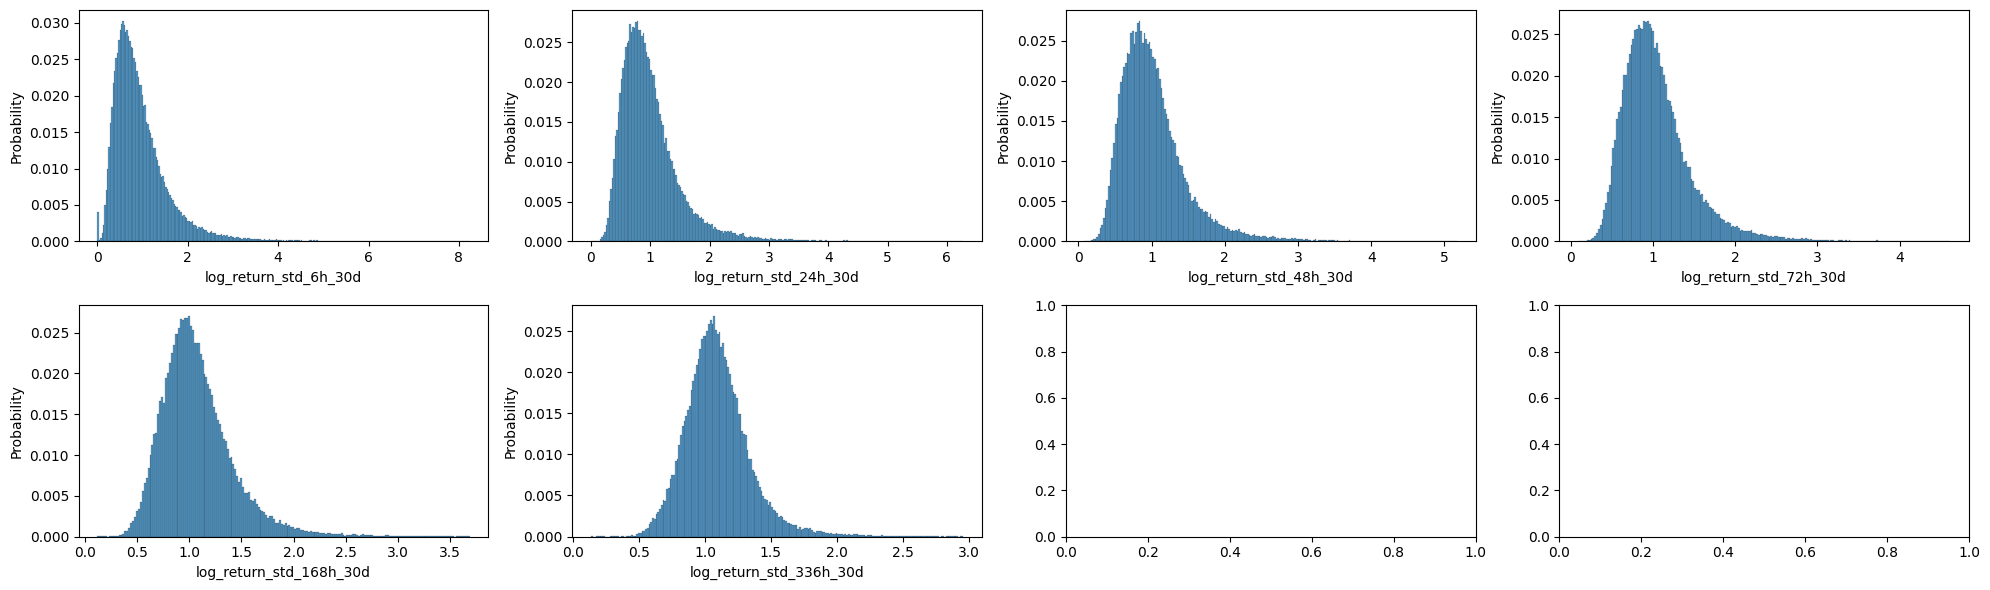

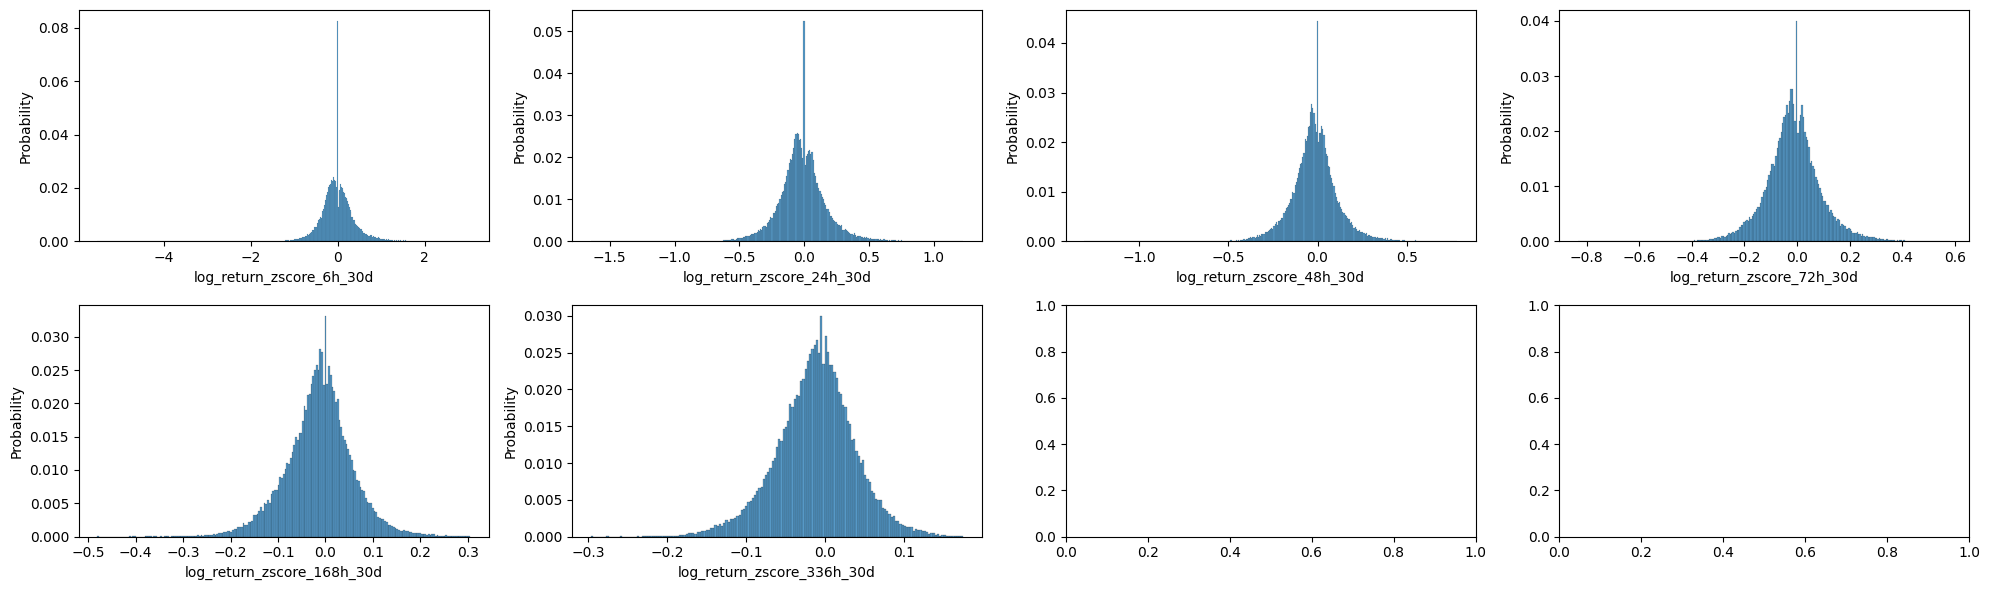

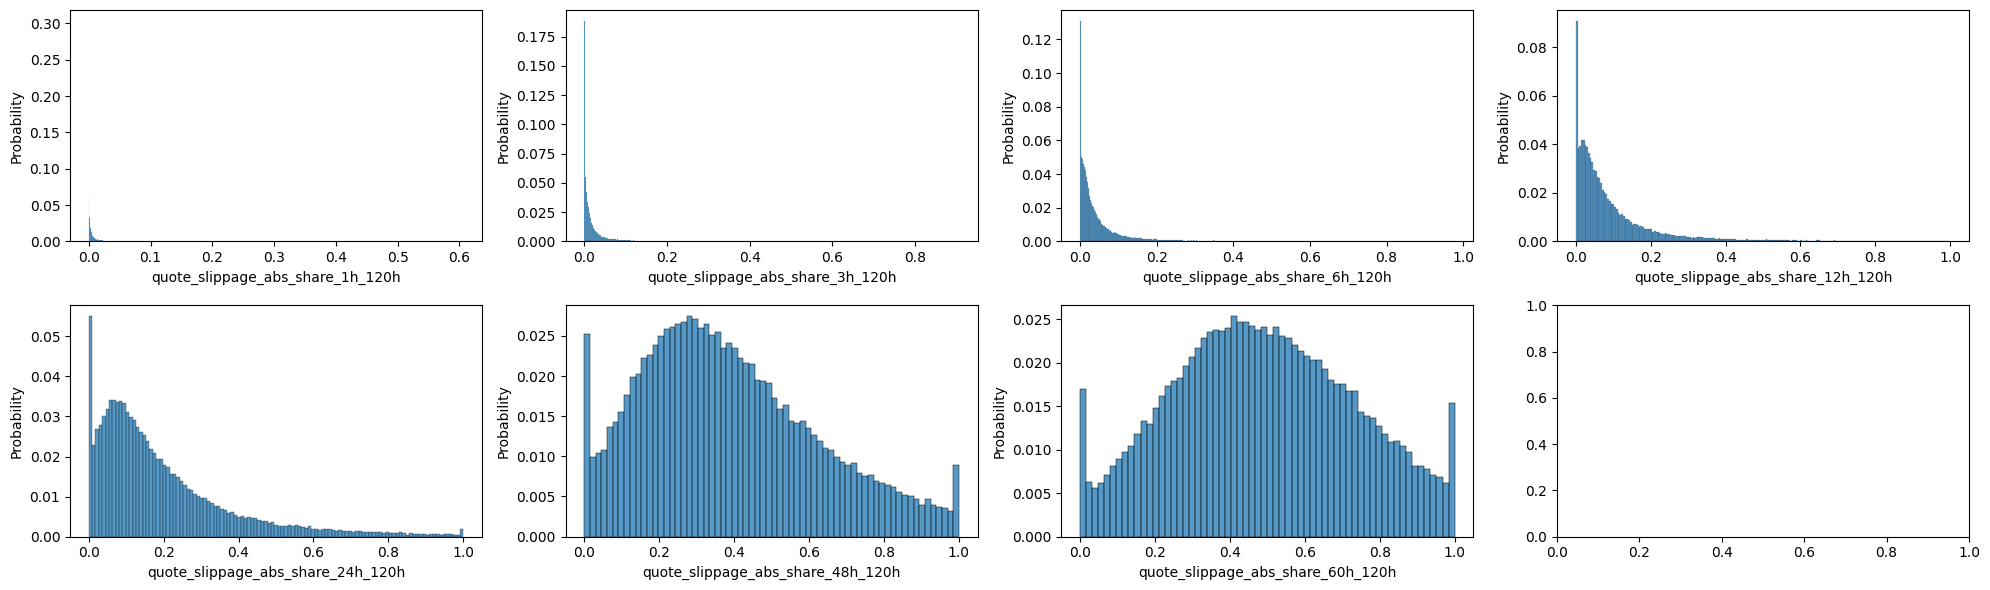

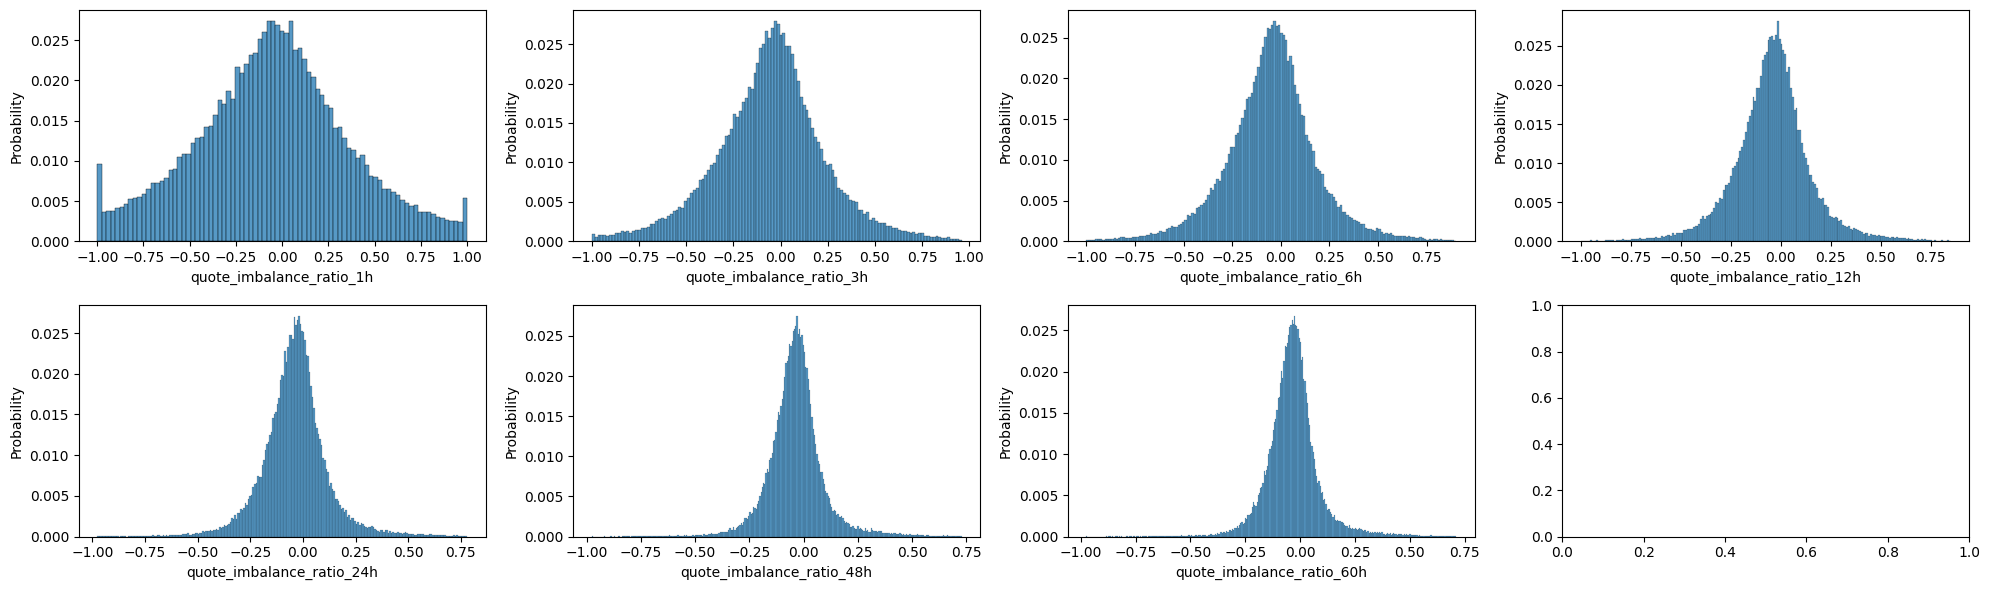

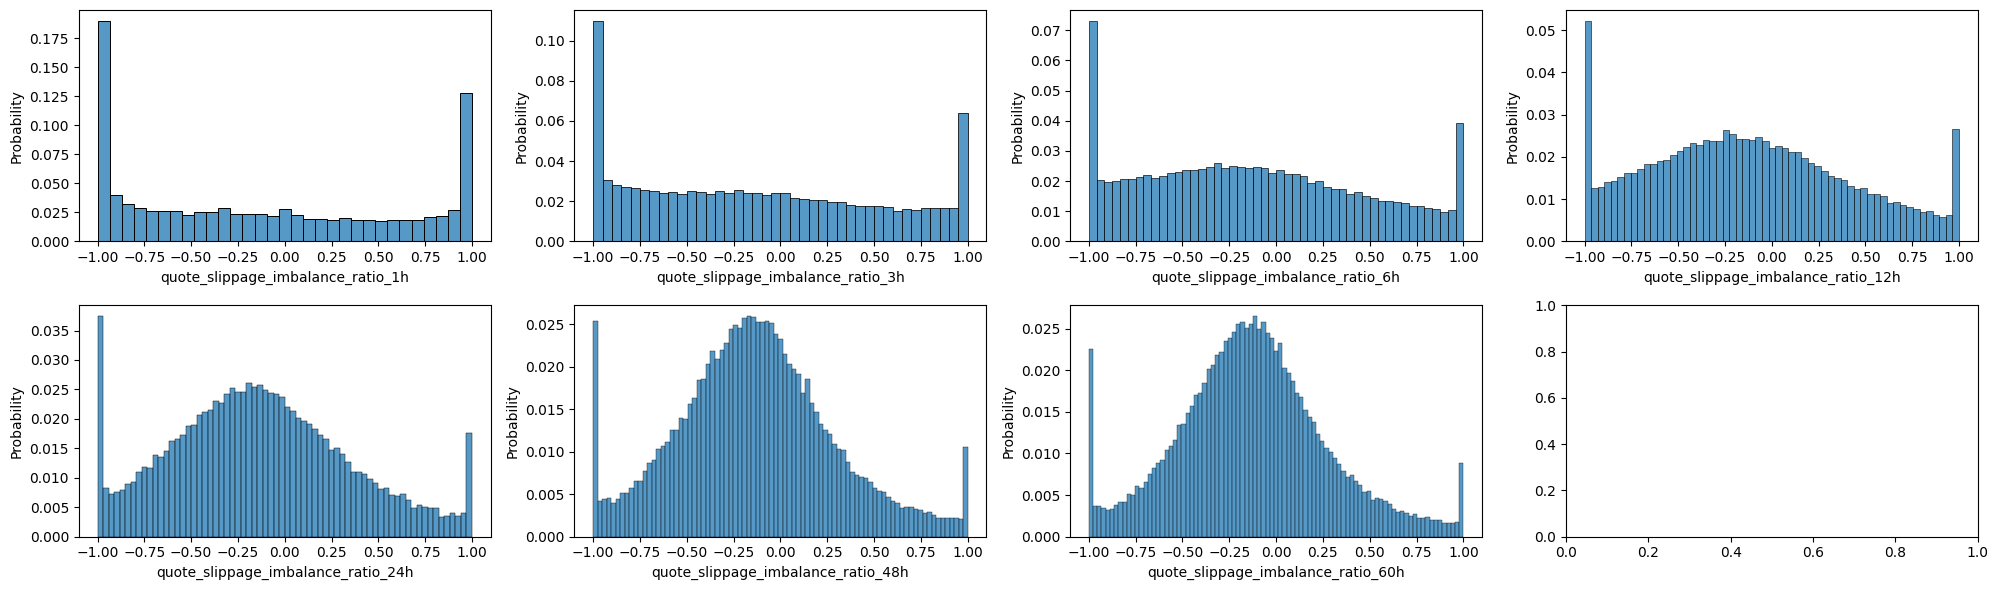

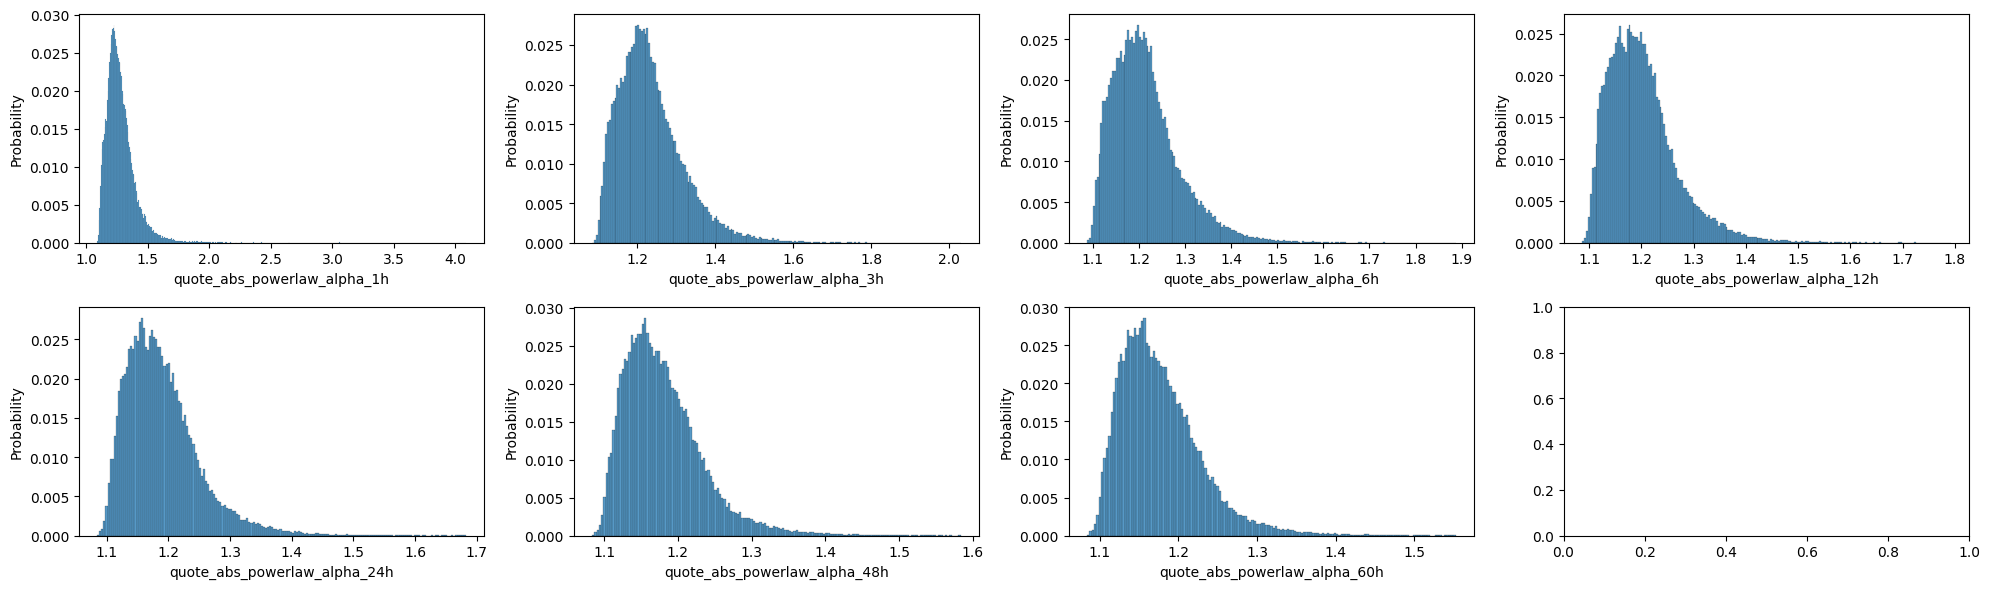

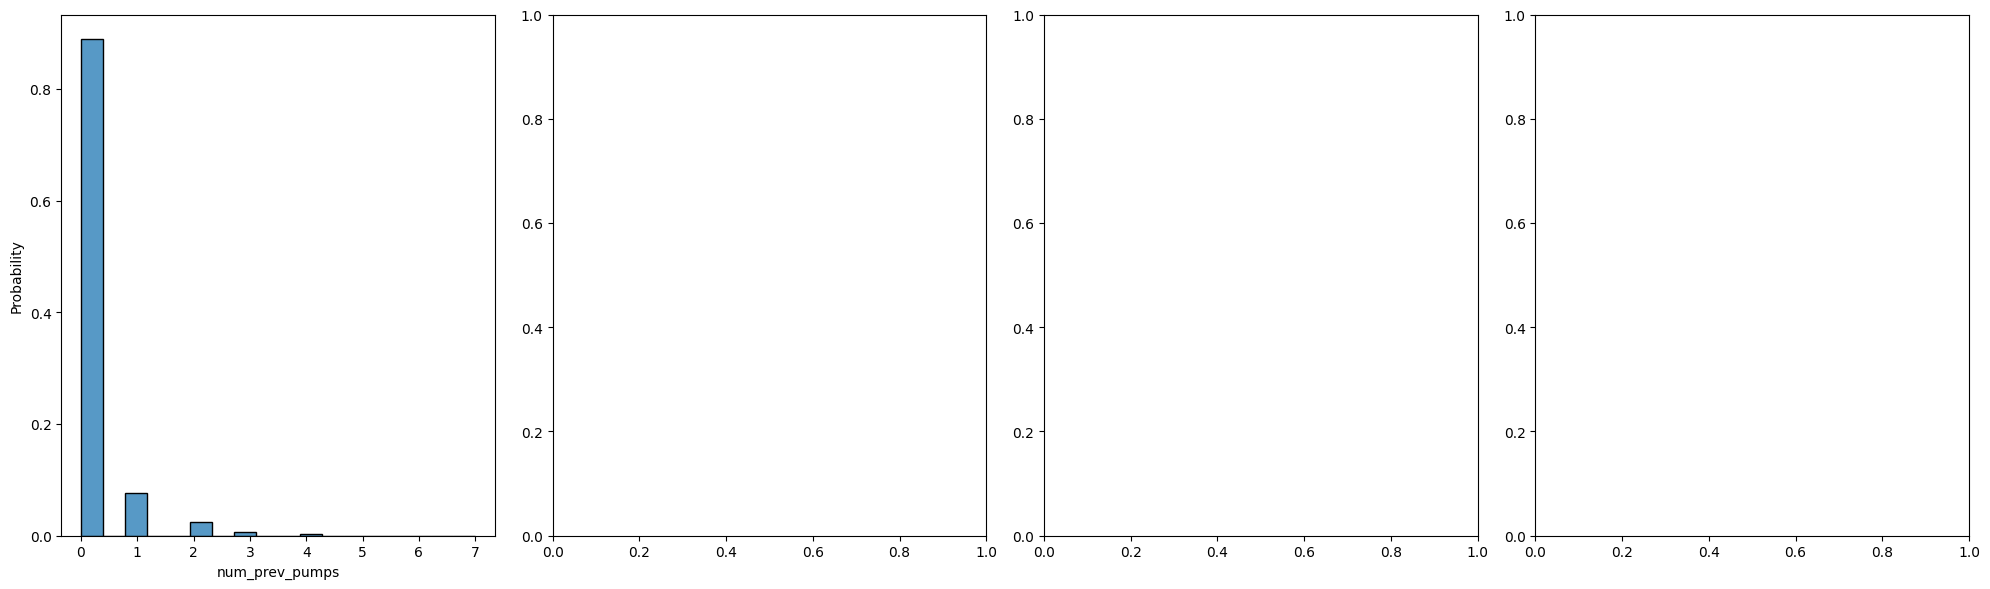

In [15]:
plot_hist_cols(df=df_filtered, col_map=col_map)

<h4>Preprocess some columns</h4>

In [16]:
groups_to_log: List[str] = [
    "volume_quote_abs_zscore",
]

In [17]:
for group in groups_to_log:
    for col in col_map[group]:
        df_filtered[col] += np.abs(df_filtered[col].min()) + 0.01 # transform features to positive to take logs
        df_filtered[col] = np.log(df_filtered[col])

100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


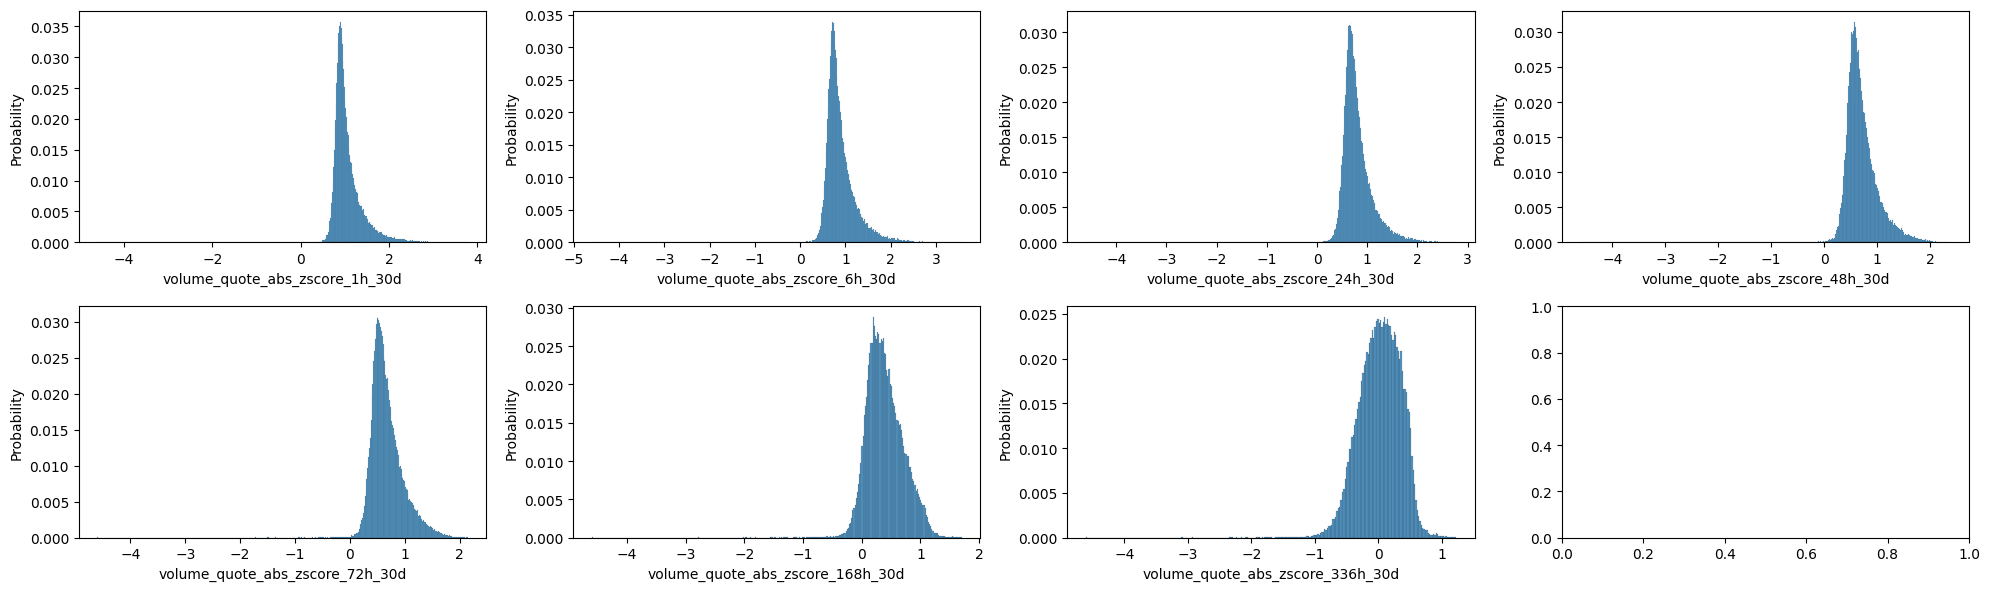

In [18]:
plot_hist_cols(
    df=df_filtered, col_map={key: val for key, val in col_map.items() if key in groups_to_log}
)

<h4>Apply cross-sectional normalization</h4>

In [19]:
groups_to_scale: List[str] = [
    "overall_return",
    "volume_quote_abs_zscore",
    "log_return_std",
    "log_return_zscore",
    "quote_abs_powerlaw_alpha",
]


cols_to_scale: List[str] = []

for group in groups_to_scale:
    cols_to_scale.extend(col_map[group])

In [20]:
df_scaled: pd.DataFrame = pd.DataFrame()

# group by pump crosssections and standardize by within moments
for i, (pump_hash, df_pump) in tqdm(enumerate(df_filtered.groupby("pump_hash"))):
    for col in cols_to_scale:
        df_pump[col] = (df_pump[col] - df_pump[col].mean()) / df_pump[col].std()

    df_scaled: pd.DataFrame = pd.concat([df_scaled, df_pump])

df_scaled["is_pumped"].value_counts()

437it [00:04, 95.27it/s] 


is_pumped
False    79507
True       437
Name: count, dtype: int64

<h4>Plot distributions with and without Crossectional Standardisation</h4>

100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


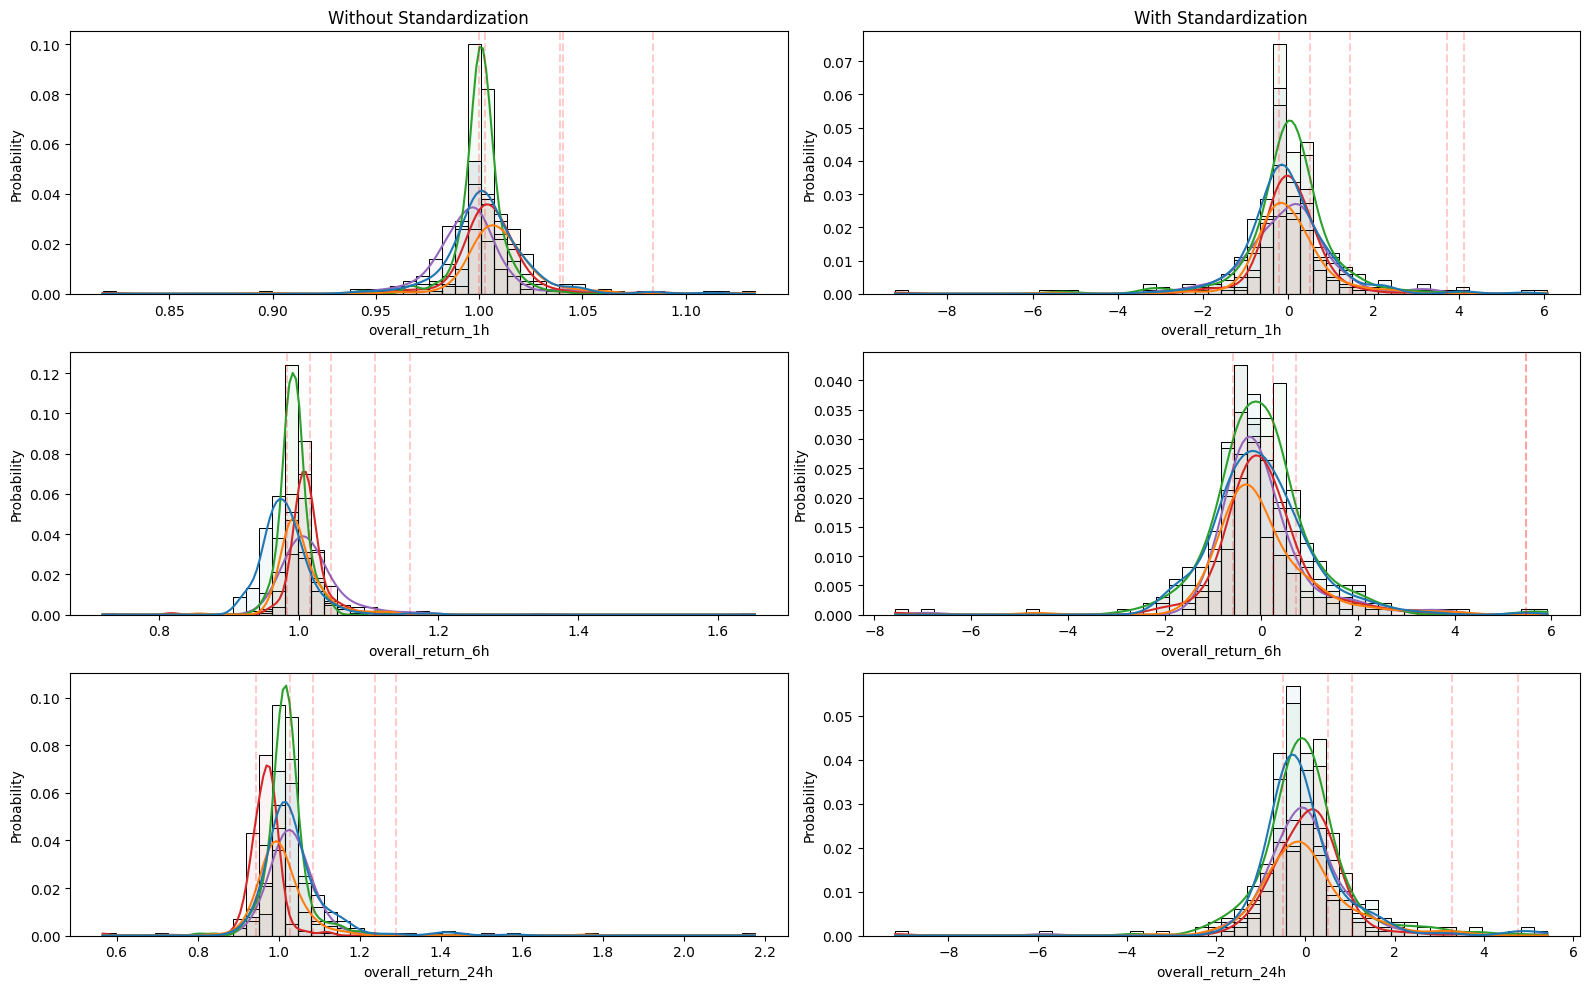

In [21]:
pumps_plot: np.array = np.random.choice(df_pumps["pump_hash"].unique(), 5, replace=False)  # choose 5 random pumps to plot

df_plot: pd.DataFrame = df_pumps[df_pumps["pump_hash"].isin(pumps_plot)].copy()
df_plot_scaled: pd.DataFrame = df_scaled[df_scaled["pump_hash"].isin(pumps_plot)].copy()

cols_to_plot = cols_to_scale[:3]

fig, axs = plt.subplots(3, 2, figsize=(16, 10))

for col, (ax1, ax2) in tqdm(zip(cols_to_plot, axs), total=3):

    # Plot not scaled and scaled hists
    sns.histplot(
        data=df_plot, x=col, hue="pump_hash", ax=ax1, legend=False, alpha=0.05, bins=50, kde=True, stat="probability"
    )
    sns.histplot(
        data=df_plot_scaled, x=col, hue="pump_hash", ax=ax2, legend=False, alpha=0.05, bins=50, kde=True, stat="probability"
    )

    for pump_hash in pumps_plot:
        pumped_ticker: pd.Series = (df_plot["pump_hash"] == pump_hash) & (df_plot["is_pumped"])
        pumped_ticker_scaled: pd.Series = (df_plot_scaled["pump_hash"] == pump_hash) & (df_plot_scaled["is_pumped"])

        ax1.axvline(x=df_plot[pumped_ticker][col].iloc[-1], color="red", linestyle="--", alpha=0.2)
        ax2.axvline(x=df_plot_scaled[pumped_ticker_scaled][col].iloc[-1], color="red", linestyle="--", alpha=0.2)

for ax, col in zip(axs[0], ["Without Standardization", "With Standardization"]):
    ax.set_title(col)


plt.tight_layout()
plt.show()

<h4>Remove failed pumps. Where pumped ticker is not among the highest in terms of returns</h4>

In [22]:
from datetime import datetime, timedelta
from dataclasses import dataclass


@dataclass
class Ticker:
    ticker: str
    time: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Ticker: {self.ticker} - {str(self.time)}"


# load trade data for a given ticker
def load_data(
    ticker: Ticker,
    lookback_delta: timedelta,
    forward_delta: timedelta = -timedelta(hours=1),  # by default it is set to -1 hours
) -> pd.DataFrame:

    end: pd.Timestamp = ticker.time + forward_delta
    start: pd.Timestamp = ticker.time - lookback_delta

    date_range: List[pd.Timestamp] = pd.date_range(start=start, end=end, freq="D", inclusive="both").tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in date_range:
        file_name: str = f"{ticker.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(ROOT_DIR, f"data/trades_parquet/binance/{ticker.ticker}", file_name)
        )
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")
    df = df[(df["time"] >= start) & (df["time"] <= end)].reset_index(drop=True)

    df["quote_abs"] = df["price"] * df["qty"]  # calculate quote spent

    return df

In [23]:
def compute_return(ticker: Ticker) -> float:
    """Calculates return of the ticker around some pump.time"""
    try:
        df_asset: pd.DataFrame = load_data(
            ticker=ticker, lookback_delta=timedelta(hours=1), forward_delta=timedelta(hours=1)
        )
    except FileNotFoundError:
        return 0

    df_asset: pd.DataFrame = df_asset[
        (df_asset["time"] >= ticker.time - timedelta(minutes=1)) & (df_asset["time"] <= ticker.time + timedelta(minutes=5))
    ].copy()

    if df_asset.empty:
        return 0

    start_price, max_price = df_asset["price"].iloc[0], df_asset["price"].max()
    asset_return: float = (max_price - start_price) / start_price

    return asset_return

In [24]:
df_returns: pd.DataFrame = pd.DataFrame()

for (pumped_ticker, pump_time), df_pump in tqdm(df_scaled.groupby(["pumped_ticker", "pump_time"])):
    tickers_crosssection: List[str] = df_pump["ticker"].tolist()
    asset_returns: List[float] = []

    for ticker in tickers_crosssection:
        ticker_obj: Ticker = Ticker(ticker=ticker, time=pump_time)
        asset_returns.append(compute_return(ticker=ticker_obj))

    df_pump["asset_return"] = asset_returns
    df_returns = pd.concat([df_returns, df_pump])

100%|██████████| 437/437 [12:51<00:00,  1.77s/it]


In [25]:
# rank assets by their max returns within each crosssection
df_returns["asset_return_rank"] = df_returns.groupby("pump_hash", sort=False)["asset_return"].rank(ascending=False, method="dense")

df_returns = (
    df_returns
    .sort_values(by="pump_time", ascending=True)
    .reset_index(drop=True)
)

df_returns.head(2)

,overall_return_1h,volume_quote_abs_zscore_1h_30d,num_trades_long_share_1h,volume_quote_long_share_1h,overall_return_6h,volume_quote_abs_zscore_6h_30d,num_trades_long_share_6h,volume_quote_long_share_6h,log_return_std_6h_30d,log_return_zscore_6h_30d,...,num_prev_pumps,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash,asset_return,asset_return_rank
0,-1.958931,1.906350,0.514627,0.454146,2.952501,0.297565,0.520890,0.534840,1.363954,2.284068,...,0,binance,PPTBTC,2018-01-03 18:00:00,YOYOBTC,False,122,PPTBTC_2018-01-03 18:00:00,0.003252,45.0
1,0.549458,-0.477371,0.519878,0.505609,-0.248082,-1.105566,0.560127,0.526801,-1.142615,-0.123710,...,0,binance,PPTBTC,2018-01-03 18:00:00,BNTBTC,False,78,PPTBTC_2018-01-03 18:00:00,0.003225,46.0


In [26]:
df_filtered_returns: pd.DataFrame = pd.DataFrame()

i = 0

for pump_id, df_pump in tqdm(df_returns.groupby("pump_hash", sort=False)):
    if df_pump[df_pump["is_pumped"]]["asset_return_rank"].iloc[0] <= 10:
        df_pump["pump_id"] = i
        df_filtered_returns = pd.concat([df_filtered_returns, df_pump])
        i += 1

df_filtered_returns["is_pumped"].value_counts()

100%|██████████| 437/437 [00:01<00:00, 229.60it/s]


is_pumped
False    71771
True       400
Name: count, dtype: int64

<h4>Train val test split</h4>

In [354]:
df_train, df_val, df_test = (
    df_filtered_returns[df_filtered_returns["pump_time"] <= "2020-09-01"].copy(),  # train sample
    df_filtered_returns[(df_filtered_returns["pump_time"] > "2020-09-01") & (df_filtered_returns["pump_time"] <= "2021-05-01")].copy(), # val sample
    df_filtered_returns[df_filtered_returns["pump_time"] > "2021-05-01"].copy(),  # test sample
)

df_train, df_val, df_test = df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

pumps: List[int] = np.array([
    df_train["is_pumped"].sum(), df_val["is_pumped"].sum(), df_test["is_pumped"].sum()
])
overall_observations = np.array([
    df_train.shape[0], df_val.shape[0], df_test.shape[0]
])

avg_cross = np.array([
    df_train.groupby("pump_id")["ticker"].count().mean(), 
    df_val.groupby("pump_id")["ticker"].count().mean(),
    df_test.groupby("pump_id")["ticker"].count().mean()
])

df_cross_stats = pd.DataFrame({ 
    "Positive": pumps,
    "Negative": overall_observations - pumps,
    "Total": overall_observations,
    "Average Crosssection Size": avg_cross
}).T.round(1)

df_cross_stats.columns = ["Train", "Validation", "Test"]


print(
    df_cross_stats.to_latex()
)

\begin{tabular}{lrrr}
\toprule
 & Train & Validation & Test \\
\midrule
Positive & 250.000000 & 90.000000 & 60.000000 \\
Negative & 36130.000000 & 19387.000000 & 16254.000000 \\
Total & 36380.000000 & 19477.000000 & 16314.000000 \\
Average Crosssection Size & 145.500000 & 216.400000 & 271.900000 \\
\bottomrule
\end{tabular}



In [28]:
# on average the size of crosssection
mean_crosssection_size: float = df_filtered_returns.groupby("pump_hash")["ticker"].count().mean()
mean_crosssection_size

180.4275

<h4>Cross-section size in time</h4>

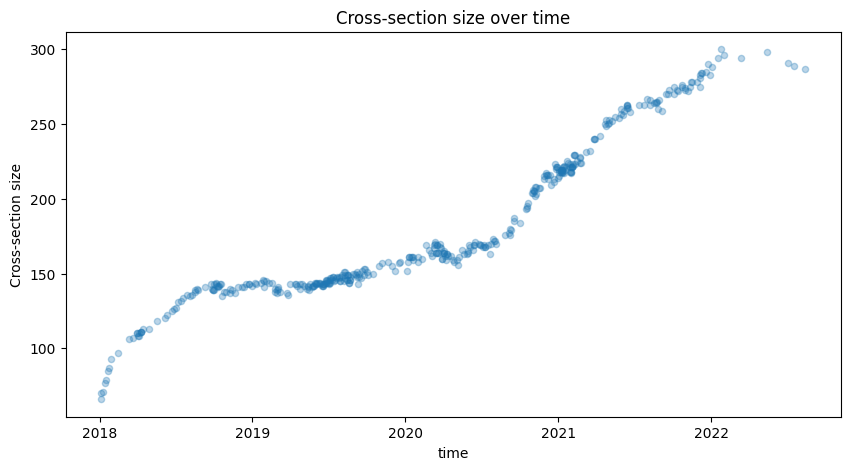

In [29]:
cross_size = []

for (pumped_ticker, pump_time), df_pump in df_filtered_returns.groupby(["pumped_ticker", "pump_time"]):
    cross_size.append(
        {"pump_time": pump_time, "pumped_ticker": pumped_ticker, "crosssection_size": df_pump["ticker"].nunique()}
    )

df_cross_size = pd.DataFrame(cross_size)
df_cross_size = df_cross_size.sort_values(by="pump_time", ascending=True).reset_index(drop=True)
df_cross_size.plot.scatter(x="pump_time", y="crosssection_size", alpha=0.3, figsize=(10, 5))

plt.title("Cross-section size over time")
plt.ylabel("Cross-section size")
plt.xlabel("time")

plt.show()

<h4>Baseline Logistic Regression</h4>

In [30]:
from sklearn.linear_model import LogisticRegression

# Train baseline Logistic Regression
model_lr = LogisticRegression(
    max_iter=int(1e10),
    class_weight={0: 1, 1: mean_crosssection_size},
)

model_lr.fit(df_train[reg_cols], df_train["is_pumped"])

probas_pred_lr_val = model_lr.predict_proba(df_val[reg_cols])[:, 1]

<h4>Plot Precision Recall Curve and compute PRAUC on validation sample</h4>

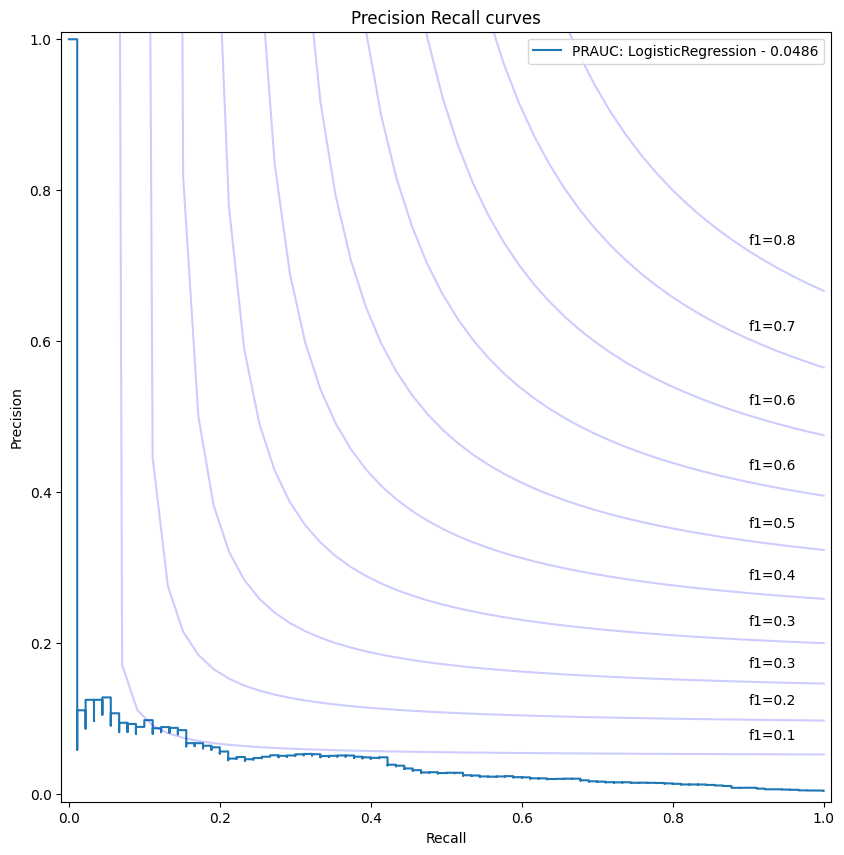

In [31]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay


def plot_precision_recall(df: pd.DataFrame, model_probas: Dict[str, np.array], figsize: Tuple[int, int] = (10, 10)) -> None:
    """Plot Precision Recall curve for the model"""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    for model_name, y_proba in model_probas.items():
        precision, recall, _ = precision_recall_curve(y_true=df["is_pumped"], probas_pred=y_proba)
        PrecisionRecallDisplay(precision=precision, recall=recall).plot(
            ax=ax, label=f"PRAUC: {model_name} - {auc(recall, precision):.4f}"
        )

    f_scores = np.linspace(0.1, 0.8, num=10)

    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
        ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    plt.legend(loc="upper right")
    plt.title("Precision Recall curves")


plot_precision_recall(df=df_val, model_probas={"LogisticRegression": probas_pred_lr_val})

<h4>Evaluation metrics</h4>


<h4>TOP-K accuracy or Hit Ratio K</h4>

In [32]:
def calculate_topk(df_test: pd.DataFrame, probas_pred: np.array, topk_bins: List[int]) -> Dict[int, float]:
    """Compute top-k accuracy of the model using validation sample"""

    topk_vals = []
    df_test["probas_pred"] = probas_pred

    for K in topk_bins:

        topk: List[bool] = []

        for _, df_test_pump in df_test.groupby("pump_hash"):
            df_test_pump: pd.DataFrame = df_test_pump.sort_values(
                by="probas_pred", ascending=False
            )  # sort tickers by logits
            topk_contains_pump: bool = df_test_pump.iloc[:K][
                "is_pumped"
            ].any()  # see if any of the top k logits has label is_pumped == 1
            topk.append(topk_contains_pump)

        topk_vals.append(sum(topk) / len(topk))  # probability of having true label in top-k logits

    return dict(zip(topk_bins, topk_vals))

In [33]:
topk_bins: List[int] = [1, 3, 5, 10, 20, 30]

topk: Dict[int, float] = calculate_topk(df_test=df_val, probas_pred=probas_pred_lr_val, topk_bins=topk_bins)
df_topk = pd.DataFrame({"K": topk.keys(), "HR@K": topk.values()})

df_topk

,K,HR@K
0,1,0.100000
1,3,0.200000
2,5,0.300000
3,10,0.411111
4,20,0.500000
5,30,0.633333


<h4>We would like to have a metric taking into account top-k performance for all Ks</h4>


$$\text{Avg} \hspace{0.25em} \frac{\partial{\text{TOP-K}}}{\partial{K}} \approx \frac{1}{|K|} \sum_{k \in K} \frac{\Delta \text{TOP-k}}{\Delta k} \hspace{1em} \text{where} \hspace{0.25em} K = \{1, 3, 5, 10, 20, 30\}$$

In [34]:
# We would like to maximize returns on increasing K
def calculate_mean_topk_derivative(df: pd.DataFrame, probas_pred: np.array, topk_bins: List[int]) -> float:
    """Calculates average mean increase in TOP-K as K increases"""
    topk: Dict[int, float] = calculate_topk(df=df, probas_pred=probas_pred, topk_bins=topk_bins)

    df_topk = pd.DataFrame({"K": topk.keys(), "HR@K": topk.values()})

    return np.mean(df_topk["HR@K"].diff() / df_topk["K"].diff())

<h4>TOP-K%</h4>

All cross-sections are of different sizes therefore it will be better to use TOP-K% instead of just K. This metric shows the probability of having a true label withing K% of the alternatives

In [35]:
def calculate_topk_percent(df: pd.DataFrame, probas_pred: np.array, topk_share_bins: np.array) -> Dict[float, float]:
    """Calculates TOP-K% for a given model and ground truth stored in df"""

    dfc: pd.DataFrame = df.copy()
    dfc["probas_pred"] = probas_pred

    topk_vals: Dict[float, List[float]] = {K: [] for K in topk_share_bins}

    for _, df_pump in dfc.groupby("pump_hash"):
        df_pump: pd.DataFrame = df_pump.sort_values(by="probas_pred", ascending=False)  # sort tickers by logits
        # calculate percentages
        df_pump = df_pump.reset_index(drop=True)  # reset index based off which we will compute percentage
        df_pump["percentage"] = (df_pump.index + 1) / df_pump.shape[0]

        for K in topk_share_bins:
            # leave observations below K% of the cross-section
            df_pump_portfolio: pd.DataFrame = df_pump[df_pump["percentage"] <= K].copy()
            topk_contains_pump: bool = df_pump_portfolio[
                "is_pumped"
            ].any()  # see if any of the top k% logits has label is_pumped == 1
            topk_vals[K].append(topk_contains_pump)

    return {K: np.mean(topk_vals[K]) for K in topk_share_bins}


calculate_topk_percent(df=df_val, probas_pred=probas_pred_lr_val, topk_share_bins=[0.1, 0.2, 0.3, 0.4, 0.5])

{0.1: 0.5333333333333333,
 0.2: 0.7111111111111111,
 0.3: 0.8333333333333334,
 0.4: 0.8777777777777778,
 0.5: 0.9}

<h4>TOP-K% AUC</h4>

In [36]:
def find_pct(df_group: pd.DataFrame) -> pd.DataFrame:
    df_group: pd.DataFrame = df_group.sort_values(by="predicted_rank", ascending=True).reset_index(drop=True)
    df_group["predicted_pct"] = (df_group.index + 1) / df_group.shape[0]

    return df_group


def calculate_topk_percent_auc(df: pd.DataFrame, probas_pred: np.ndarray) -> float:
    df["probas_pred"] = probas_pred
    df["predicted_rank"] = df.groupby("pump_id")["probas_pred"].rank(ascending=False, method="first")

    dfc: pd.DataFrame = df.groupby("pump_id").apply(find_pct).reset_index(drop=True).copy()

    X = np.arange(0.01, 1.01, 0.01)
    probas_contain_pump: List[float] = []

    for K in X:
        df_slice: pd.DataFrame = dfc[dfc["predicted_pct"] <= K].copy()

        probas_contain_pump.append(df_slice.groupby("pump_id")["is_pumped"].any().sum() / df_slice["pump_id"].nunique())

    return auc(x=X, y=probas_contain_pump)

In [37]:
calculate_topk_percent_auc(df=df_val, probas_pred=probas_pred_lr_val)

0.8282222222222222

In [38]:
%timeit calculate_topk_percent_auc(df=df_val, probas_pred=probas_pred_lr_val)

395 ms ± 4.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<h4>Logistic Regression Tuned</h4>

<p>We added regulirization to Logistic Regression to see if it can further improve it</p>

<h4>Find the best set of hyperparameters using Optuna</h4>

In [39]:
from optuna.trial import Trial
from functools import partial

import optuna


def objective_lr(
    trial: Trial, df_train: pd.DataFrame, df_val: pd.DataFrame, reg_cols: List[str], target: str
) -> Tuple[float, float]:
    """Optimize LogisticRegression hyperparameters to maximize TOP-K% AUC evaluation metric"""

    lr_params = dict(
        class_weight={0: 1, 1: trial.suggest_float("class_weight", 10, 300)},
        penalty="l1",
        solver="liblinear",
        max_iter=10000,
        n_jobs=-1,
        C=1 / trial.suggest_float("lambda", 10, 1000),  # C = 1/lambda
    )

    model = LogisticRegression(**lr_params)
    model = model.fit(X=df_train[reg_cols], y=df_train[target])
    # Predict probas for validation fold
    probas_pred: np.array = model.predict_proba(df_val[reg_cols])[:, 1]  # for minority class

    topk_percent_auc: float = calculate_topk_percent_auc(df=df_val, probas_pred=probas_pred)

    return topk_percent_auc

In [40]:
# run optuna study to maximize top_k over hyperparams
study_lr = optuna.create_study(direction="maximize")

study_lr.optimize(
    partial(objective_lr, df_train=df_train, df_val=df_val, reg_cols=reg_cols, target="is_pumped"), n_trials=20
)

[I 2024-08-20 16:07:50,289] A new study created in memory with name: no-name-2b63d18d-8b15-44f3-bda2-02ccb0726d36
[I 2024-08-20 16:07:50,803] Trial 0 finished with value: 0.8291666666666666 and parameters: {'class_weight': 10.080271108828551, 'lambda': 557.5576270267918}. Best is trial 0 with value: 0.8291666666666666.
[I 2024-08-20 16:07:51,389] Trial 1 finished with value: 0.8334999999999999 and parameters: {'class_weight': 228.8004037448705, 'lambda': 552.7955108993183}. Best is trial 1 with value: 0.8334999999999999.
[I 2024-08-20 16:07:52,032] Trial 2 finished with value: 0.8333333333333333 and parameters: {'class_weight': 237.53501471215506, 'lambda': 571.9852539566048}. Best is trial 1 with value: 0.8334999999999999.
[I 2024-08-20 16:07:52,641] Trial 3 finished with value: 0.8339444444444445 and parameters: {'class_weight': 284.55829268964857, 'lambda': 767.9730785163248}. Best is trial 3 with value: 0.8339444444444445.
[I 2024-08-20 16:07:53,221] Trial 4 finished with value: 0.

In [41]:
l1_lambda = study_lr.best_params["lambda"]
class_weight = study_lr.best_params["class_weight"]

model_lr_tuned = LogisticRegression(
    class_weight={0: 1, 1: class_weight}, penalty="l1", 
    solver="liblinear", max_iter=10000, n_jobs=-1, C=1/l1_lambda
)

model_lr_tuned.fit(df_train[reg_cols], df_train["is_pumped"])

LogisticRegression(C=0.0030043950778752934,
                   class_weight={0: 1, 1: 115.5011078379224}, max_iter=10000,
                   n_jobs=-1, penalty='l1', solver='liblinear')

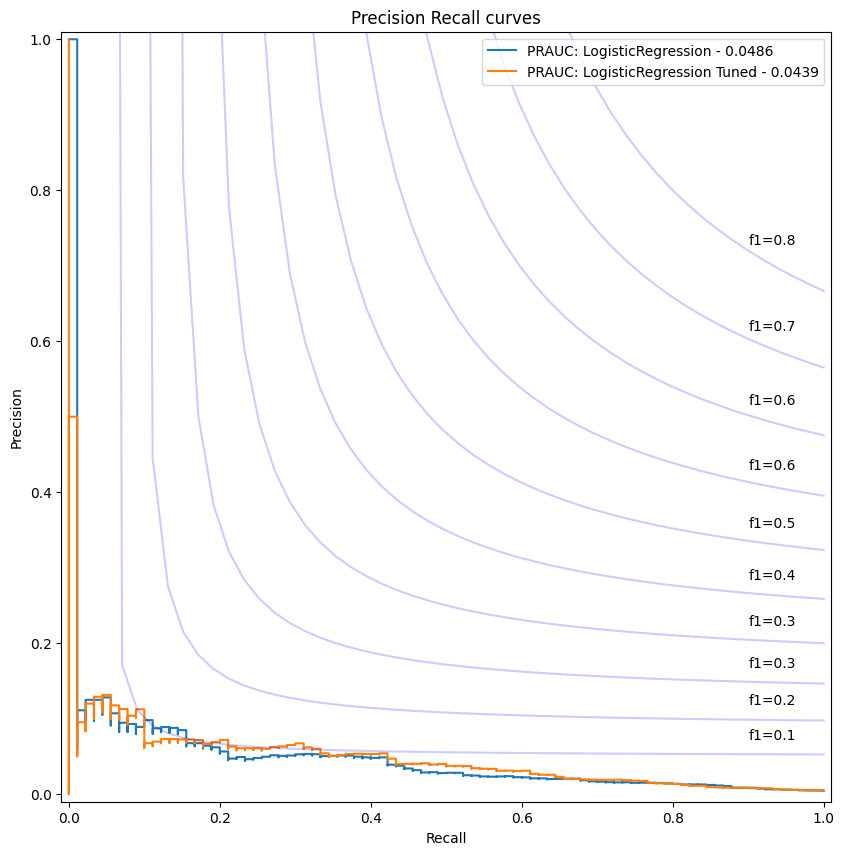

In [42]:
probas_pred_lr_tuned_val = model_lr_tuned.predict_proba(df_val[reg_cols])[:, 1]

ax = plot_precision_recall(
    df=df_val, model_probas={"LogisticRegression": probas_pred_lr_val, "LogisticRegression Tuned": probas_pred_lr_tuned_val}
)

plt.show()

In [43]:
calculate_topk(df_test=df_val, probas_pred=probas_pred_lr_tuned_val, topk_bins=topk_bins)

{1: 0.08888888888888889,
 3: 0.2222222222222222,
 5: 0.3111111111111111,
 10: 0.4444444444444444,
 20: 0.5555555555555556,
 30: 0.6666666666666666}

<h4>RandomForest Classifier</h4>

In [44]:
from sklearn.ensemble import RandomForestClassifier
from optuna.trial import Trial
from functools import partial


def objective_rf(
    trial: Trial, df_train: pd.DataFrame, df_val: pd.DataFrame, reg_cols: List[str], target: str
) -> Tuple[float, float]:
    """Optimize RandomForest hyperparameters to maximize TOP-K% AUC evaluation metric"""

    model = RandomForestClassifier(
        criterion="gini",
        class_weight={0: 1, 1: trial.suggest_float("class_weight", 10, 300)},
        max_features=trial.suggest_float("max_features", 0.5, 1),
        max_samples=trial.suggest_float("max_samples", 0.5, 1),
        n_jobs=-1,  # use all 24 cpu cores
        max_depth=trial.suggest_int("max_depth", 2, 10),
        # number of trees grown in our ensemble
        n_estimators=trial.suggest_int("n_estimators", 100, 2000),
    )
    model.fit(X=df_train[reg_cols], y=df_train[target])

    # Predict probas for validation fold
    probas_pred: np.array = model.predict_proba(df_val[reg_cols])[:, 1]  # for minority class
    topk_percent_auc: float = calculate_topk_percent_auc(df=df_val, probas_pred=probas_pred)

    return topk_percent_auc  # return top-k auc

In [45]:
# run optuna study to maximize top_k over hyperparams
study_rf = optuna.create_study(direction="maximize")

study_rf.optimize(
    partial(objective_rf, df_train=df_train, df_val=df_val, reg_cols=reg_cols, target="is_pumped"), 
    n_trials=10
)

[I 2024-08-20 16:08:13,910] A new study created in memory with name: no-name-5a1bb1e1-9d3f-45a8-a964-cc58f26a27a8
[I 2024-08-20 16:08:18,695] Trial 0 finished with value: 0.8442222222222222 and parameters: {'class_weight': 231.16452519045734, 'max_features': 0.67831830573156, 'max_samples': 0.8981863822511147, 'max_depth': 2, 'n_estimators': 384}. Best is trial 0 with value: 0.8442222222222222.
[I 2024-08-20 16:09:32,951] Trial 1 finished with value: 0.853111111111111 and parameters: {'class_weight': 29.127980473524868, 'max_features': 0.9843318048756451, 'max_samples': 0.9839859662627762, 'max_depth': 7, 'n_estimators': 1369}. Best is trial 1 with value: 0.853111111111111.
[I 2024-08-20 16:09:47,268] Trial 2 finished with value: 0.821 and parameters: {'class_weight': 176.94991390384163, 'max_features': 0.5199490071104438, 'max_samples': 0.83541197785077, 'max_depth': 7, 'n_estimators': 571}. Best is trial 1 with value: 0.853111111111111.
[I 2024-08-20 16:09:56,078] Trial 3 finished wi

In [46]:
class_weight = study_rf.best_params["class_weight"]

rf_params = {
    **study_rf.best_params,
    "criterion": "gini",
    "n_jobs": -1,
    "class_weight": {0: 1, 1: class_weight}
}

model_rf = RandomForestClassifier(**rf_params)
model_rf.fit(df_train[reg_cols], df_train["is_pumped"])

RandomForestClassifier(class_weight={0: 1, 1: 29.127980473524868}, max_depth=7,
                       max_features=0.9843318048756451,
                       max_samples=0.9839859662627762, n_estimators=1369,
                       n_jobs=-1)

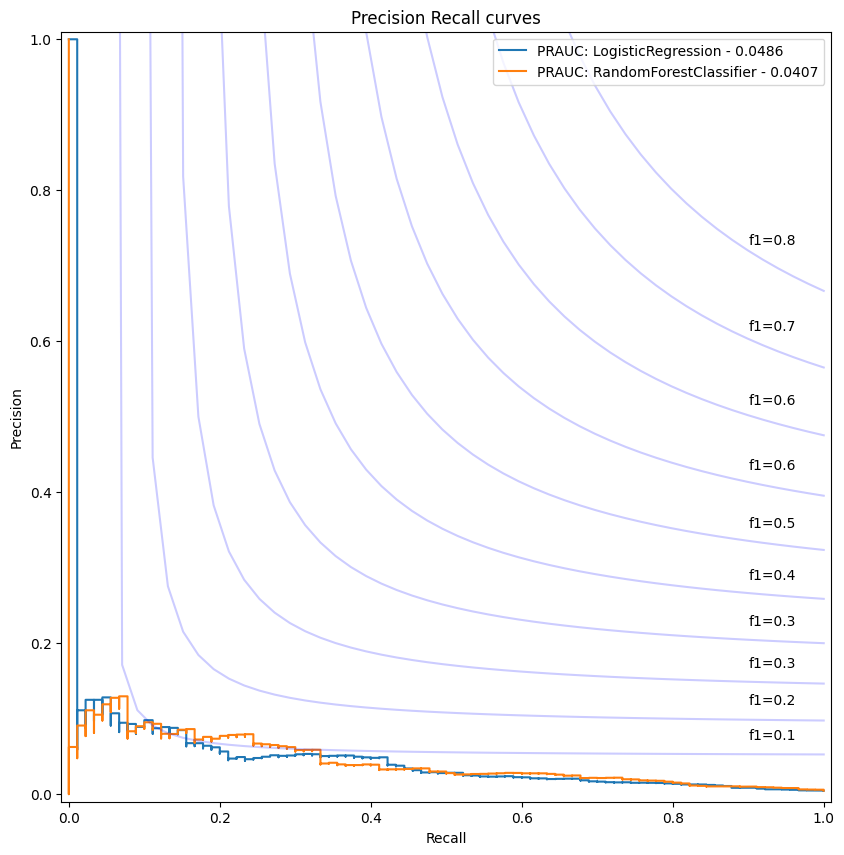

In [47]:
probas_pred_rf_val = model_rf.predict_proba(df_val[reg_cols])[:, 1]

ax = plot_precision_recall(
    df=df_val, model_probas={"LogisticRegression": probas_pred_lr_val, "RandomForestClassifier": probas_pred_rf_val}
)

plt.show()

In [48]:
calculate_topk(df_test=df_val, probas_pred=probas_pred_rf_val, topk_bins=topk_bins)

{1: 0.08888888888888889,
 3: 0.17777777777777778,
 5: 0.2777777777777778,
 10: 0.4,
 20: 0.5666666666666667,
 30: 0.6777777777777778}

<h4>CatboostClassifier</h4>

In [49]:
# wrap topk_pct_auc into custom catboost metric

class TOPKPAUCMetric:
    def is_max_optimal(self):
        return True  # greater is better

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        y_true = np.array(target).astype(int)
        # we want to eval on the validation sample so if there is a mismatch then catboost tries to evaluate on train which we dont need
        if df_val.shape[0] != len(approx):
            train_topkp_auc: float = calculate_topk_percent_auc(
                df=df_train, probas_pred=approx
            )
            return train_topkp_auc, 1

        val_topkp_auc: float = calculate_topk_percent_auc(
            df=df_val, probas_pred=approx
        )

        return val_topkp_auc, 1

    def get_final_error(self, error, weight):
        return error

In [87]:
from catboost import CatBoostClassifier, Pool
import catboost as cb


def objective_catboost(
    trial: Trial, df_train: pd.DataFrame, df_val: pd.DataFrame, reg_cols: List[str], target: str
) -> float:

    cb_params = {
        "objective": "Logloss",
        "sampling_frequency": "PerTree",
        "num_boost_round": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.7, 1),
        "subsample": trial.suggest_float("subsample", 0.7, 1),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "auto_class_weights": "Balanced",
    }

    ptrain: Pool = Pool(data=df_train[reg_cols], label=df_train[target], cat_features=["num_prev_pumps"])
    pval: Pool = Pool(data=df_val[reg_cols], label=df_val[target], cat_features=["num_prev_pumps"])

    # Fit the model with early stopping
    model = CatBoostClassifier(
        **cb_params, verbose=False,
    )
    
    model.fit(ptrain, eval_set=pval, early_stopping_rounds=50, use_best_model=True)

    # Predict probas for validation fold
    probas_pred: np.array = model.predict_proba(pval)[:, 1]  # for minority class
    topk_percent_auc: float = calculate_topk_percent_auc(df=df_val, probas_pred=probas_pred)

    return topk_percent_auc

In [ ]:
study_catboost = optuna.create_study(direction="maximize")

study_catboost.optimize(
    partial(objective_catboost, df_train=df_train, df_val=df_val, reg_cols=reg_cols, target="is_pumped"), 
    n_trials=100
)

<h4>Train Catboost with Logloss early stopping</h4>

In [89]:
cb_params = {
    "objective": "Logloss",
    "sampling_frequency": "PerTree",
    "num_boost_round": 1000,
}

cb_params.update(study_catboost.best_params)

In [357]:
ptrain: Pool = Pool(data=df_train[reg_cols], label=df_train["is_pumped"], cat_features=["num_prev_pumps"])
pval: Pool = Pool(data=df_val[reg_cols], label=df_val["is_pumped"], cat_features=["num_prev_pumps"])
ptest: Pool = Pool(data=df_test[reg_cols], label=df_test["is_pumped"], cat_features=["num_prev_pumps"])

In [90]:
model_cb = CatBoostClassifier(
    **cb_params, use_best_model=True
)

model_cb.fit(
    ptrain, eval_set=pval, early_stopping_rounds=50, plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6646612	test: 0.6645213	best: 0.6645213 (0)	total: 57.8ms	remaining: 57.7s
1:	learn: 0.6371941	test: 0.6368777	best: 0.6368777 (1)	total: 112ms	remaining: 55.8s
2:	learn: 0.6106233	test: 0.6101009	best: 0.6101009 (2)	total: 164ms	remaining: 54.4s
3:	learn: 0.5850974	test: 0.5844602	best: 0.5844602 (3)	total: 217ms	remaining: 54.1s
4:	learn: 0.5603593	test: 0.5595378	best: 0.5595378 (4)	total: 270ms	remaining: 53.7s
5:	learn: 0.5372776	test: 0.5365078	best: 0.5365078 (5)	total: 323ms	remaining: 53.5s
6:	learn: 0.5152333	test: 0.5146055	best: 0.5146055 (6)	total: 375ms	remaining: 53.2s
7:	learn: 0.4943061	test: 0.4936304	best: 0.4936304 (7)	total: 430ms	remaining: 53.3s
8:	learn: 0.4741663	test: 0.4732889	best: 0.4732889 (8)	total: 487ms	remaining: 53.7s
9:	learn: 0.4546232	test: 0.4535863	best: 0.4535863 (9)	total: 546ms	remaining: 54s
10:	learn: 0.4359686	test: 0.4351854	best: 0.4351854 (10)	total: 604ms	remaining: 54.3s
11:	learn: 0.4185829	test: 0.4176683	best: 0.4176683 

In [91]:
probas_pred_catboost_val = model_cb.predict_proba(pval)[:, 1]

calculate_topk(df_test=df_val, probas_pred=probas_pred_catboost_val, topk_bins=topk_bins)

{1: 0.14444444444444443,
 3: 0.25555555555555554,
 5: 0.28888888888888886,
 10: 0.45555555555555555,
 20: 0.6555555555555556,
 30: 0.7222222222222222}

<h4>Catboost with TOPKPAUC. Custom eval metric used for early stopping</h4>

In [92]:
model_cb_custom = CatBoostClassifier(
    **cb_params, eval_metric=TOPKPAUCMetric(), use_best_model=True
)

model_cb_custom.fit(
    ptrain, eval_set=pval, early_stopping_rounds=50, plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5284607	test: 0.4794444	best: 0.4794444 (0)	total: 1.8s	remaining: 30m 2s
1:	learn: 0.5145600	test: 0.5137222	best: 0.5137222 (1)	total: 3.43s	remaining: 28m 29s
2:	learn: 0.4844607	test: 0.7041111	best: 0.7041111 (2)	total: 5.07s	remaining: 28m 6s
3:	learn: 0.4864015	test: 0.7347222	best: 0.7347222 (3)	total: 6.72s	remaining: 27m 53s
4:	learn: 0.4802607	test: 0.7343889	best: 0.7347222 (3)	total: 8.36s	remaining: 27m 44s
5:	learn: 0.4764015	test: 0.7428333	best: 0.7428333 (5)	total: 10.1s	remaining: 27m 59s
6:	learn: 0.4821615	test: 0.7382222	best: 0.7428333 (5)	total: 11.7s	remaining: 27m 45s
7:	learn: 0.4825215	test: 0.7360000	best: 0.7428333 (5)	total: 13.3s	remaining: 27m 32s
8:	learn: 0.4809215	test: 0.7470556	best: 0.7470556 (8)	total: 14.9s	remaining: 27m 17s
9:	learn: 0.4831215	test: 0.7490000	best: 0.7490000 (9)	total: 16.4s	remaining: 27m 6s
10:	learn: 0.4844815	test: 0.7516667	best: 0.7516667 (10)	total: 18.2s	remaining: 27m 15s
11:	learn: 0.4845615	test: 0.75061

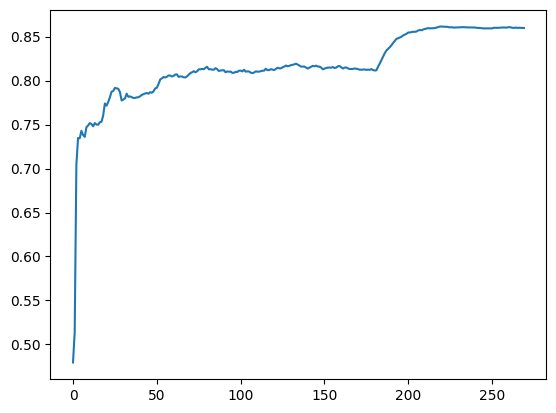

In [93]:
# plot TOPKAUC metric
plt.plot(
    model_cb_custom.get_evals_result()["validation"]["TOPKPAUCMetric"]
)

plt.show()

In [94]:
probas_pred_catboost_custom_val = model_cb_custom.predict_proba(pval)[:, 1]

<h4>Validation</h4>

In [95]:
model_probas_val: Dict[str, np.ndarray] = {
    "LogisticRegression": probas_pred_lr_val,
    "LogisticRegression Tuned": probas_pred_lr_tuned_val,
    "RandomForest Tuned": probas_pred_rf_val,
    "CatBoostClassifier Tuned": probas_pred_catboost_val,
    "CatBoostClassifier Tuned + TOPKAUC EarlyStopping": probas_pred_catboost_custom_val
}


def plot_topk_results(df:pd.DataFrame, model_probas: Dict[str, np.ndarray], topk_bins: List[int]) -> pd.DataFrame:
    res = []

    for model, proba in model_probas.items():
        topk_vals = calculate_topk(
            df_test=df, probas_pred=proba, topk_bins=topk_bins
        ).values()

        res.append(list(topk_vals))

    df_topk = pd.DataFrame(data=res).T

    df_topk.columns = model_probas.keys()
    df_topk.index = [f"TOP-{i}" for i in topk_bins]

    return df_topk

In [59]:
plot_topk_results(
    df=df_val, model_probas=model_probas_val, topk_bins=topk_bins
)

,LogisticRegression,LogisticRegression Tuned,RandomForest Tuned,CatBoostClassifier Tuned,CatBoostClassifier Tuned + TOPKAUC EarlyStopping
TOP-1,0.100000,0.088889,0.088889,0.155556,0.122222
TOP-3,0.200000,0.222222,0.177778,0.255556,0.288889
TOP-5,0.300000,0.311111,0.277778,0.300000,0.311111
TOP-10,0.411111,0.444444,0.400000,0.466667,0.477778
TOP-20,0.500000,0.555556,0.566667,0.666667,0.666667
TOP-30,0.633333,0.666667,0.677778,0.711111,0.733333


<h4>Test performance</h4>

In [227]:
probas_pred_lr_test = model_lr.predict_proba(df_test[reg_cols])[:, 1]
probas_pred_lr_tuned_test = model_lr_tuned.predict_proba(df_test[reg_cols])[:, 1]
probas_pred_rf_test = model_lr_tuned.predict_proba(df_test[reg_cols])[:, 1]
probas_pred_catboost_test = model_cb.predict_proba(ptest)[:, 1]
probas_pred_catboost_custom_test = model_cb_custom.predict_proba(ptest)[:, 1]


model_probas_test: Dict[str, np.ndarray] = {
    "LogisticRegression": probas_pred_lr_test,
    "LogisticRegression Tuned": probas_pred_lr_tuned_test,
    "RandomForest Tuned": probas_pred_rf_test,
    "CatBoostClassifier Tuned": probas_pred_catboost_test,
    "CatBoostClassifier Tuned + TOPKAUC EarlyStopping": probas_pred_catboost_custom_test,
}

plot_topk_results(df=df_test, model_probas=model_probas_test, topk_bins=topk_bins)

,LogisticRegression,LogisticRegression Tuned,RandomForest Tuned,CatBoostClassifier Tuned,CatBoostClassifier Tuned + TOPKAUC EarlyStopping
TOP-1,0.016667,0.000000,0.000000,0.033333,0.050000
TOP-3,0.083333,0.100000,0.100000,0.150000,0.183333
TOP-5,0.133333,0.216667,0.216667,0.250000,0.300000
TOP-10,0.316667,0.333333,0.333333,0.383333,0.450000
TOP-20,0.450000,0.483333,0.483333,0.516667,0.533333
TOP-30,0.566667,0.566667,0.566667,0.600000,0.650000


<h4>Ranking</h4>

In [99]:
def find_pct(df_group: pd.DataFrame) -> pd.DataFrame:
    df_group: pd.DataFrame = df_group.sort_values(by="predicted_rank", ascending=True).reset_index(drop=True)
    df_group["predicted_pct"] = (df_group.index + 1) / df_group.shape[0]
    return df_group


def calculate_topk_percent_auc_ranking(df: pd.DataFrame, relevance_scores: np.ndarray) -> float:
    df["relevance_score"] = relevance_scores
    df["predicted_rank"] = df.groupby("pump_id")["relevance_score"].rank(ascending=False, method="first")

    dfc: pd.DataFrame = df.groupby("pump_id").apply(find_pct).reset_index(drop=True).copy()

    X = np.arange(0.01, 1.01, 0.01)
    probas_contain_pump: List[float] = []

    for K in X:
        df_slice: pd.DataFrame = dfc[dfc["predicted_pct"] <= K].copy()
        probas_contain_pump.append(df_slice.groupby("pump_id")["is_pumped"].any().sum() / df_slice["pump_id"].nunique())
    
    return auc(x=X, y=probas_contain_pump)

In [100]:
class TOPKPAUCMetricRanking:
    def is_max_optimal(self):
        return True  # greater is better

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        # we want to eval on the validation sample so if there is a mismatch then catboost tries to evaluate on train which we dont need
        if df_val.shape[0] != len(approx):
            train_topkp_auc: float = calculate_topk_percent_auc_ranking(df=df_train, relevance_scores=approx)
            return train_topkp_auc, 1

        val_topkp_auc: float = calculate_topk_percent_auc_ranking(df=df_val, relevance_scores=approx)

        return val_topkp_auc, 1

    def get_final_error(self, error, weight):
        return error

In [101]:
from catboost import CatBoostRanker


def objective_cb_ranking(
    trial: Trial, df_train: pd.DataFrame, df_val: pd.DataFrame, reg_cols: List[str], target_col: str
) -> float:

    cb_params = {
        "objective": "YetiRankPairwise",
        "sampling_frequency": "PerTree",
        "num_boost_round": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.7, 1),
        "subsample": trial.suggest_float("subsample", 0.7, 1),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
    }

    ptrain: Pool = Pool(
        data=df_train[reg_cols], 
        cat_features=["num_prev_pumps"], 
        label=df_train[target_col], 
        group_id=df_train["pump_id"]
    )

    pval: Pool = Pool(
        data=df_val[reg_cols],
        cat_features=["num_prev_pumps"],
        label=df_val[target_col],
        group_id=df_val["pump_id"],
    )

    model = CatBoostRanker(**cb_params, verbose=False)

    model.fit(ptrain, eval_set=pval, early_stopping_rounds=50, use_best_model=True)

    # Predict rankings on validation sample
    relevance_scores: np.array = model.predict(pval)
    topkp_auc: float = calculate_topk_percent_auc_ranking(df=df_val, relevance_scores=relevance_scores)

    return topkp_auc

In [98]:
def compute_asset_relevance(asset_returns: pd.Series) -> pd.Series:
    return asset_returns.rank(ascending=True, method="first") / len(asset_returns)

In [102]:
# compute asset_relevance as the return pct

df_train["asset_relevance"] = (
    df_train
    .groupby("pump_id", sort=False)["asset_return"]
    .apply(compute_asset_relevance)
    .reset_index(level=0, drop=True)
)

df_val["asset_relevance"] = (
    df_val
    .groupby("pump_id", sort=False)["asset_return"]
    .apply(compute_asset_relevance)
    .reset_index(level=0, drop=True)
)

In [ ]:
# run optuna study to maximize top_k over hyperparams
study_ranking = optuna.create_study(direction="maximize")

study_ranking.optimize(
    partial(objective_cb_ranking, df_train=df_train, df_val=df_val, reg_cols=reg_cols, target_col="asset_relevance"),
    n_trials=25,
)

In [104]:
cb_ranker_params = {
    "objective": "YetiRankPairwise",
    "sampling_frequency": "PerTree",
    "num_boost_round": 1000,
}

cb_ranker_params.update(study_ranking.best_params)

ptrain: Pool = Pool(
    data=df_train[reg_cols], 
    cat_features=["num_prev_pumps"], 
    label=df_train["asset_relevance"], 
    group_id=df_train["pump_id"]
)

pval: Pool = Pool(
    data=df_val[reg_cols],
    cat_features=["num_prev_pumps"],
    label=df_val["asset_relevance"],
    group_id=df_val["pump_id"],
)

cb_ranker = CatBoostRanker(**cb_ranker_params, eval_metric=TOPKPAUCMetricRanking())

cb_ranker = cb_ranker.fit(
    ptrain, eval_set=pval, early_stopping_rounds=50,
    plot=True, use_best_model=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Pairwise scoring loss functions on CPU do not support one hot features. OneHotMaxSize set to 1
0:	learn: 0.5219600	test: 0.6259444	best: 0.6259444 (0)	total: 1.88s	remaining: 31m 15s
1:	learn: 0.5264000	test: 0.6260000	best: 0.6260000 (1)	total: 3.57s	remaining: 29m 39s
2:	learn: 0.5278000	test: 0.6306111	best: 0.6306111 (2)	total: 5.42s	remaining: 30m
3:	learn: 0.5308800	test: 0.6423889	best: 0.6423889 (3)	total: 7.01s	remaining: 29m 5s
4:	learn: 0.5257600	test: 0.6428889	best: 0.6428889 (4)	total: 8.59s	remaining: 28m 28s
5:	learn: 0.5270400	test: 0.6384444	best: 0.6428889 (4)	total: 10.3s	remaining: 28m 27s
6:	learn: 0.5258000	test: 0.6348889	best: 0.6428889 (4)	total: 11.9s	remaining: 28m 5s
7:	learn: 0.5268400	test: 0.6452222	best: 0.6452222 (7)	total: 13.5s	remaining: 27m 49s
8:	learn: 0.5233600	test: 0.6440000	best: 0.6452222 (7)	total: 15s	remaining: 27m 33s
9:	learn: 0.5248400	test: 0.6405556	best: 0.6452222 (7)	total: 16.6s	remaining: 27m 19s
10:	learn: 0.5264400	test: 0.6383

In [260]:
def compute_topk_ranking(df: pd.DataFrame, relevance_scores: np.ndarray, topk_bins: List[int]) -> Dict[str, float]:

    df["relevance_score"] = relevance_scores
    df["predicted_rank"] = df.groupby("pump_id")["relevance_score"].rank(ascending=False, method="first")

    num_pumps_train: int = df["is_pumped"].sum()
    topk_scores: List[float] = []

    for K in topk_bins:
        num_caught_pumps: int = df[
            df["is_pumped"] & (df["predicted_rank"] <= K)
        ].shape[0]

        topk_scores.append(
            # topk-recall
            num_caught_pumps / num_pumps_train
        )

    return dict(zip(topk_bins, topk_scores))


def compute_topkp_ranking(df: pd.DataFrame, relevance_scores: np.ndarray, topk_share_bins: List[float]):
    df["relevance_score"] = relevance_scores
    df["predicted_rank"] = df.groupby("pump_id")["relevance_score"].rank(ascending=False, method="first")

    dfc: pd.DataFrame = df.groupby("pump_id").apply(find_pct).reset_index(drop=True).copy()

    probas_contain_pump: List[float] = []

    for K in topk_share_bins:
        df_slice: pd.DataFrame = dfc[dfc["predicted_pct"] <= K].copy()
        probas_contain_pump.append(df_slice.groupby("pump_id")["is_pumped"].any().sum() / df_slice["pump_id"].nunique())

    return dict(zip(topk_share_bins, probas_contain_pump))

In [246]:
relevance_scores: np.ndarray = cb_ranker.predict(pval)

compute_topk_ranking(
    df=df_val, relevance_scores=relevance_scores, topk_bins=topk_bins
)

{1: 0.0,
 3: 0.07777777777777778,
 5: 0.1111111111111111,
 10: 0.2111111111111111,
 20: 0.35555555555555557,
 30: 0.43333333333333335}

In [247]:
compute_topkp_ranking(
    df=df_val, relevance_scores=relevance_scores, topk_share_bins=[0.01, 0.05, 0.1, 0.2, 0.5]
)

{0.01: 0.17777777777777778,
 0.05: 0.4888888888888889,
 0.1: 0.6444444444444445,
 0.2: 0.7777777777777778,
 0.5: 0.9111111111111111}

In [248]:
calculate_topk_percent_auc_ranking(
    df=df_val, relevance_scores=relevance_scores
)

0.6576111111111111

<h4>Validation results</h4>

In [256]:
relevance_scores: np.ndarray = cb_ranker.predict(pval)

val_results: pd.DataFrame = plot_topk_results(df=df_val, model_probas=model_probas_val, topk_bins=topk_bins)

val_results["CatboostRanker Tuned"] = compute_topk_ranking(
    df=df_val, relevance_scores=relevance_scores, topk_bins=topk_bins
).values()

val_results

,LogisticRegression,LogisticRegression Tuned,RandomForest Tuned,CatBoostClassifier Tuned,CatBoostClassifier Tuned + TOPKAUC EarlyStopping,CatboostRanker Tuned
TOP-1,0.100000,0.088889,0.088889,0.144444,0.133333,0.000000
TOP-3,0.200000,0.222222,0.177778,0.255556,0.266667,0.077778
TOP-5,0.300000,0.311111,0.277778,0.288889,0.355556,0.111111
TOP-10,0.411111,0.444444,0.400000,0.455556,0.488889,0.211111
TOP-20,0.500000,0.555556,0.566667,0.655556,0.644444,0.355556
TOP-30,0.633333,0.666667,0.677778,0.722222,0.744444,0.433333


In [250]:
# Validation topkp results
def plot_topkp_results(df: pd.DataFrame, model_probas: Dict[str, np.ndarray], topk_share_bins: List[float]) -> pd.DataFrame:
    res = []

    for model, proba in tqdm(model_probas.items()):
        topk_vals = calculate_topk_percent(df=df, probas_pred=proba, topk_share_bins=topk_share_bins).values()
        res.append(list(topk_vals))

    df_topk = pd.DataFrame(data=res).T

    df_topk.columns = model_probas.keys()
    df_topk.index = [f"TOP-{i}%" for i in topk_share_bins]

    return df_topk

In [251]:
val_results_topkp: pd.DataFrame = plot_topkp_results(
    df=df_val, model_probas=model_probas_val, topk_share_bins=[0.01, 0.05, 0.1, 0.2, 0.5]
)

100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


In [252]:
val_results_topkp["CatboostRanker Tuned"] = compute_topkp_ranking(
    df=df_val, relevance_scores=relevance_scores, topk_share_bins=[0.01, 0.05, 0.1, 0.2, 0.5]
).values()

val_results_topkp

,LogisticRegression,LogisticRegression Tuned,RandomForest Tuned,CatBoostClassifier Tuned,CatBoostClassifier Tuned + TOPKAUC EarlyStopping,CatboostRanker Tuned
TOP-0.01%,0.133333,0.155556,0.133333,0.200000,0.177778,0.177778
TOP-0.05%,0.422222,0.444444,0.411111,0.455556,0.488889,0.488889
TOP-0.1%,0.533333,0.555556,0.588889,0.666667,0.644444,0.644444
TOP-0.2%,0.711111,0.744444,0.777778,0.733333,0.777778,0.777778
TOP-0.5%,0.900000,0.911111,0.922222,0.933333,0.911111,0.911111


<h4>Test results</h4>

In [258]:
relevance_scores: np.ndarray = cb_ranker.predict(ptest)

test_results: pd.DataFrame = plot_topk_results(df=df_test, model_probas=model_probas_test, topk_bins=topk_bins)

test_results["CatboostRanker Tuned"] = compute_topk_ranking(
    df=df_test, relevance_scores=relevance_scores, topk_bins=topk_bins
).values()

test_results

,LogisticRegression,LogisticRegression Tuned,RandomForest Tuned,CatBoostClassifier Tuned,CatBoostClassifier Tuned + TOPKAUC EarlyStopping,CatboostRanker Tuned
TOP-1,0.016667,0.000000,0.000000,0.033333,0.050000,0.050000
TOP-3,0.083333,0.100000,0.100000,0.150000,0.183333,0.100000
TOP-5,0.133333,0.216667,0.216667,0.250000,0.300000,0.116667
TOP-10,0.316667,0.333333,0.333333,0.383333,0.450000,0.150000
TOP-20,0.450000,0.483333,0.483333,0.516667,0.533333,0.233333
TOP-30,0.566667,0.566667,0.566667,0.600000,0.650000,0.300000


In [287]:
# test topkp results
test_results_topkp: pd.DataFrame = plot_topkp_results(
    df=df_test, model_probas=model_probas_test, topk_share_bins=np.arange(0.01, 1.01, 0.01)
)

test_results_topkp["CatboostRanker Tuned"] = compute_topkp_ranking(
    df=df_test, relevance_scores=relevance_scores, topk_share_bins=np.arange(0.01, 1.01, 0.01)
).values()

test_results_topkp

100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


,LogisticRegression,LogisticRegression Tuned,RandomForest Tuned,CatBoostClassifier Tuned,CatBoostClassifier Tuned + TOPKAUC EarlyStopping,CatboostRanker Tuned
TOP-0.01%,0.033333,0.066667,0.066667,0.083333,0.100000,0.083333
TOP-0.02%,0.150000,0.216667,0.216667,0.250000,0.300000,0.116667
TOP-0.03%,0.250000,0.250000,0.250000,0.350000,0.450000,0.133333
TOP-0.04%,0.316667,0.333333,0.333333,0.383333,0.450000,0.150000
TOP-0.05%,0.350000,0.400000,0.400000,0.400000,0.483333,0.150000
...,...,...,...,...,...,...
TOP-0.9600000000000001%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TOP-0.97%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TOP-0.98%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TOP-0.99%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [288]:
# output
test_results_topkp = test_results_topkp.drop(columns=["LogisticRegression"])

In [289]:
test_results_topkp.columns = [
    "LogisticRegression",
    "RandomForest",
    "CatboostClassifier",
    "CatboostClassifier + ES",
    "CatboostRanker",
]

test_results_topkp.index = np.arange(0.01, 1.01, 0.01)
test_results_topkp

,LogisticRegression,RandomForest,CatboostClassifier,CatboostClassifier + ES,CatboostRanker
0.01,0.066667,0.066667,0.083333,0.100000,0.083333
0.02,0.216667,0.216667,0.250000,0.300000,0.116667
0.03,0.250000,0.250000,0.350000,0.450000,0.133333
0.04,0.333333,0.333333,0.383333,0.450000,0.150000
0.05,0.400000,0.400000,0.400000,0.483333,0.150000
...,...,...,...,...,...
0.96,1.000000,1.000000,1.000000,1.000000,1.000000
0.97,1.000000,1.000000,1.000000,1.000000,1.000000
0.98,1.000000,1.000000,1.000000,1.000000,1.000000
0.99,1.000000,1.000000,1.000000,1.000000,1.000000


In [312]:
auc_vals = []

for col in test_results_topkp.columns:
    auc_vals.append(
        auc(x=np.arange(0.01, 1.01, 0.01), y=test_results_topkp[col])
    )


[0.8306666666666667,
 0.8306666666666667,
 0.8354166666666667,
 0.8511666666666667,
 0.6340833333333333]

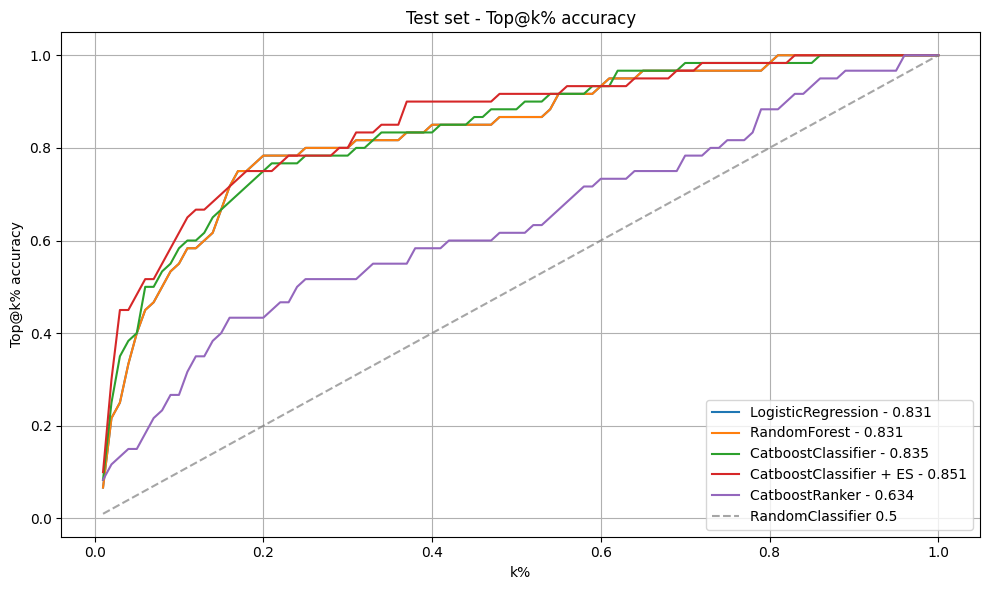

In [356]:
X = np.arange(0.01, 1.01, 0.01)

test_results_topkp.index = X

test_results_topkp.plot(grid=True, figsize=(10, 6))
plt.plot(X, X, color="grey", alpha=0.7, linestyle="--", label="RandomClassifier")

plt.legend()
plt.xlabel("k%")
plt.ylabel("Top@k% accuracy")
plt.title("Test set - Top@k% accuracy")

plt.legend([
    f"{col} - {auc_vals[i]:.3f}" for i, col in enumerate(test_results_topkp.columns)
] + ["RandomClassifier 0.5"])

plt.tight_layout()
plt.grid(True)

plt.savefig("topkp_auc_test.png", dpi=300)

<h4>Pool predictions of all models</h4>

In [110]:
class EnsembledModel:

    def __init__(self, pretrained_models_cfg: List[Tuple[str, Any, bool]], reg_cols: List[str]):
        self.pretrained_models_cfg: List[Tuple[Any, bool]] = pretrained_models_cfg
        self.reg_cols: List[str] = reg_cols

    def predict_crosssection(self, df_crosssection: pd.DataFrame) -> pd.DataFrame:
        ranks, names = [], []

        for model_cfg in self.pretrained_models_cfg:
            name, model, requires_ranking = model_cfg
            names.append(name)

            if requires_ranking:
                df_crosssection["probas_pred"] = model.predict_proba(df_crosssection[self.reg_cols])[:, 1]
                df_crosssection["predicted_rank"] = df_crosssection["probas_pred"].rank(ascending=False, method="dense")
            else:
                df_crosssection["relevance_scores"] = model.predict(df_crosssection[self.reg_cols])
                df_crosssection["predicted_rank"] = df_crosssection["relevance_scores"].rank(ascending=False, method="dense")

            ranks.append(
                df_crosssection["predicted_rank"].tolist()
            )

        df_ranks = pd.DataFrame(np.array(ranks).T)
        df_ranks.columns = names
        df_ranks["avg_rank"] = df_ranks.mean(axis=1)
        df_ranks["is_pumped"] = df_crosssection["is_pumped"].tolist()
        df_ranks["ticker"] = df_crosssection["ticker"].tolist()

        return df_ranks

    def _eval_topk_accuracy_crosssection(self, df_crosssection: pd.DataFrame, topk_bins: pd.DataFrame) -> Dict[int, bool]:
        df_ranks: pd.DataFrame = self.predict_crosssection(df_crosssection=df_crosssection)
        df_ranks = df_ranks.sort_values(by="avg_rank", ascending=True).reset_index(drop=True)

        topk_identity: List[bool] = []

        for K in topk_bins:
            topk_contains_pump: bool = df_ranks["is_pumped"][:K].any()
            topk_identity.append(topk_contains_pump)

        return dict(zip(topk_bins, topk_identity))

    def eval_topk_accuracy(self, df: pd.DataFrame, topk_bins: List[str]) -> pd.Series:
        topk_res: List[Dict[int, bool]] = []

        for pump_id, df_crosssection in tqdm(df.groupby("pump_id", sort=False)):
            topk_identity: Dict[int, bool] = self._eval_topk_accuracy_crosssection(df_crosssection=df_crosssection, topk_bins=topk_bins)
            topk_res.append(topk_identity)

        return pd.DataFrame(topk_res).sum() / df["pump_id"].nunique()


    def predict_crosssection_proba(self, df_crosssection: pd.DataFrame) -> pd.DataFrame:
        ranks, names = [], []

        for model_cfg in self.pretrained_models_cfg:
            name, model, requires_ranking = model_cfg
            names.append(name)

            if requires_ranking:
                df_crosssection["probas_pred"] = model.predict_proba(df_crosssection[self.reg_cols])[:, 1]
                df_crosssection["predicted_rank"] = df_crosssection["probas_pred"].rank(ascending=False, method="dense")
            else:
                df_crosssection["relevance_scores"] = model.predict(df_crosssection[self.reg_cols])
                df_crosssection["predicted_rank"] = df_crosssection["relevance_scores"].rank(ascending=False, method="dense")

            ranks.append(df_crosssection["predicted_rank"].tolist())

        df_ranks = pd.DataFrame(np.array(ranks).T)
        df_ranks.columns = names
        df_ranks["avg_rank"] = df_ranks.mean(axis=1)

        return df_ranks

    # implement predict_proba for Portfolio backtest
    def predict_proba(self, df_crosssection: pd.DataFrame) -> np.ndarray:
        # Higher value should correspond to likely pump
        df_ranks: pd.DataFrame = self.predict_crosssection_proba(df_crosssection=df_crosssection)
        probas = (df_ranks["avg_rank"].max() - df_ranks["avg_rank"]).values.reshape(-1, 1)
        return np.hstack(
            [np.ones(df_crosssection.shape[0]).reshape(-1, 1), probas]
        )

In [132]:
pretrained_models_cfg = [
    ("LogisticRegression", model_lr, True),
    ("LogisticRegression Tuned", model_lr_tuned, True),
    ("RandomForestClassifier Tuned", model_rf, True),
    ("CatBoostClassifier Tuned", model_cb, True),
    ("CatBoostClassifier Tuned + TOPKAUC EarlyStopping", model_cb_custom, True),
    # ("CatBoostRanker Tuned", cb_ranker, False)
]

pooled_model = EnsembledModel(pretrained_models_cfg=pretrained_models_cfg, reg_cols=reg_cols)

<h4>Ensembled validation results</h4>

In [148]:
pooled_topk_val: pd.Series = pooled_model.eval_topk_accuracy(df=df_train, topk_bins=topk_bins)
val_results["Ensembled Model"] = pooled_topk_val.tolist()

val_results

100%|██████████| 250/250 [00:23<00:00, 10.78it/s]


,LogisticRegression,LogisticRegression Tuned,RandomForest Tuned,CatBoostClassifier Tuned,CatBoostClassifier Tuned + TOPKAUC EarlyStopping,CatboostRanker Tuned,Ensembled Model
TOP-1,0.100000,0.088889,0.088889,0.144444,0.133333,0.000000,0.140
TOP-3,0.200000,0.222222,0.177778,0.255556,0.266667,0.077778,0.268
TOP-5,0.300000,0.311111,0.277778,0.288889,0.355556,0.111111,0.352
TOP-10,0.411111,0.444444,0.400000,0.455556,0.488889,0.211111,0.496
TOP-20,0.500000,0.555556,0.566667,0.655556,0.644444,0.355556,0.660
TOP-30,0.633333,0.666667,0.677778,0.722222,0.744444,0.433333,0.760


<h4>Ensembled test results</h4>

In [134]:
pooled_topk_test: pd.Series = pooled_model.eval_topk_accuracy(df=df_test, topk_bins=topk_bins)
test_results["Ensembled Model"] = pooled_topk_test.tolist()

test_results

100%|██████████| 60/60 [00:06<00:00,  8.96it/s]


,LogisticRegression,LogisticRegression Tuned,RandomForest Tuned,CatBoostClassifier Tuned,CatBoostClassifier Tuned + TOPKAUC EarlyStopping,CatboostRanker Tuned,Ensembled Model
TOP-1,0.016667,0.000000,0.000000,0.033333,0.050000,0.050000,0.050000
TOP-3,0.083333,0.100000,0.100000,0.150000,0.183333,0.100000,0.133333
TOP-5,0.133333,0.216667,0.216667,0.250000,0.300000,0.116667,0.216667
TOP-10,0.316667,0.333333,0.333333,0.383333,0.450000,0.150000,0.400000
TOP-20,0.450000,0.483333,0.483333,0.516667,0.533333,0.233333,0.516667
TOP-30,0.566667,0.566667,0.566667,0.600000,0.650000,0.300000,0.583333


In [176]:
test_results = test_results.drop(columns=["LogisticRegression", "Ensembled Model"])

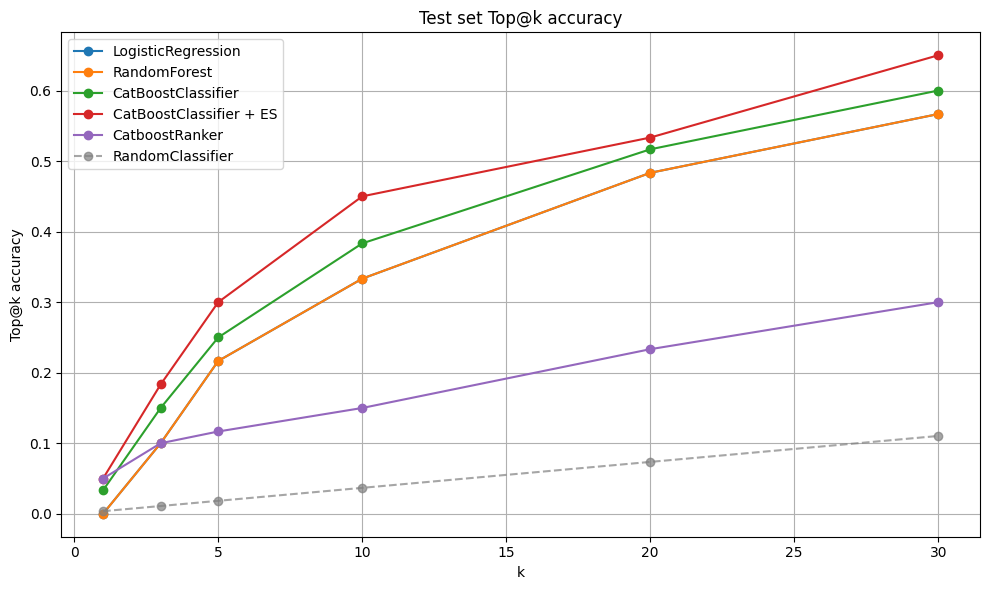

In [189]:
test_results.index = [1, 3, 5, 10, 20, 30]

test_results.columns = [
    "LogisticRegression",
    "RandomForest",
    "CatBoostClassifier",
    "CatBoostClassifier + ES",
    "CatboostRanker",
]


test_results.plot(marker="o", grid=True, figsize=(10, 6))

pd.Series(np.array(topk_bins) / (df_test.pump_id.value_counts().values).mean(), index=topk_bins).plot(
    marker="o", grid=True, color="grey", alpha=0.7, linestyle="--", label="RandomClassifier"
)

plt.legend()
plt.xlabel("k")
plt.ylabel("Top@k accuracy")
plt.title("Test set Top@k accuracy")

plt.legend()

plt.tight_layout()
plt.savefig("topk_accuracy_test.png", dpi=300)

<h4>Portfolio based strategy backtest</h4>

<h4>Calculate model profitability on val/test samples</h4>

<ol>
    <li>We make a prediction based on data we have and obtain logits for the current cross-section</li>
    <li>We create a portfolio weighted by logits or some other weighting and buy it after prediction. This implies that we buy up to 1 hour prior to the pump</li>
    <li>We hold the portfolio until some condition is met, pumped asset reached a certain required return (like 30%) or some time since the pump has passed</li>
    <li>After all of this we calculate the return of such portfolio</li>
</ol>

In [135]:
from abc import ABC, abstractmethod
from dataclasses import asdict


@dataclass
class PumpEvent(Ticker):
    ticker: str
    time: str


@dataclass
class Portfolio:

    tickers: List[str]
    weights: np.ndarray[float]

    def __repr__(self) -> str:
        return f"Portfolio: {dict(zip(self.tickers, self.weights.round(4)))}"

    def get_weight(self, ticker: str) -> float:
        """Return weight of the asset in the portfolio"""
        return self.weights[self.tickers.index(ticker)]


@dataclass
class Transaction:
    ticker: str
    buy_price: float
    sell_price: float
    buy_ts: pd.Timestamp
    sell_ts: pd.Timestamp

    def to_dict(self):
        return {k: str(v) for k, v in asdict(self).items()}


class PortfolioTester(ABC):

    def __init__(self, model):
        self.model = model
        self.log: pd.DataFrame = pd.DataFrame()

    @abstractmethod
    def create_portfolio(self, df_probas: pd.DataFrame, pump: PumpEvent) -> Portfolio:
        """Returns a dict of portfolio weights"""

    @abstractmethod
    def sell_portfolio(self, portfolio: Portfolio, pump: PumpEvent) -> List[Transaction]:
        """returns pd.DataFrame of transactions. In this method describe all entries and exit prices"""

    def calculate_portfolio_return(self, transactions: List[Transaction], portfolio: Portfolio) -> float:
        """
        transactions = [
            Transaction(ticker="ADABTC", buy_price=0.004, sell_price=0.005, buy_ts=buy_ts, sell_ts=sell_ts}
        ]
        """
        TRADE_COMMISION: float = 0.0025
        portfolio_return: float = 0
        transaction: Transaction

        for transaction in transactions:
            asset_return = (transaction.sell_price - transaction.buy_price) / transaction.buy_price
            portfolio_return += asset_return * portfolio.get_weight(transaction.ticker)

        return portfolio_return - TRADE_COMMISION

    def load_data(
        self, ticker: str, pivot_ts: pd.Timestamp, lookback_delta: timedelta, forward_delta: timedelta
    ) -> pd.DataFrame:
        """Load ticke level data from local storage"""
        start: pd.Timestamp = pivot_ts - lookback_delta
        end: pd.Timestamp = pivot_ts + forward_delta

        date_range: List[pd.Timestamp] = pd.date_range(start=start, end=end, freq="D", inclusive="both").tolist()
        df: pd.DataFrame = pd.DataFrame()

        for date in date_range:
            file_name: str = f"{ticker}-trades-{date.date()}.parquet"
            df_date: pd.DataFrame = pd.read_parquet(
                os.path.join(ROOT_DIR, f"data/trades_parquet/binance/{ticker}", file_name)
            )
            df = pd.concat([df, df_date])

        df["time"] = pd.to_datetime(df["time"], unit="ms")
        df = df[(df["time"] >= start) & (df["time"] <= end)].reset_index(drop=True)
        df["quote_abs"] = df["price"] * df["qty"]  # calculate quote spent

        return df

    def get_buy_price(self, df_ticker: pd.DataFrame, buy_ts: pd.Timestamp) -> float:
        """Get the price closest to buy_ts timestamp and return the corresponding price"""
        df_ticker["ts_delta"] = np.abs(df_ticker["time"] - buy_ts)
        # find minimum abs difference in time to get the closest price
        buy_price: float = df_ticker[df_ticker["ts_delta"] == df_ticker["ts_delta"].min()]["price"].iloc[0]
        return buy_price

    def get_sell_price(self, df_ticker: pd.DataFrame, pump: PumpEvent) -> Tuple[float, pd.Timestamp]:
        """
        Get the sell price closest to sell_ts which is essentially pump.time. This method is called for assets that were misclassified
        by the model which are immediately sold at pump.time
        """
        df_ticker["ts_delta"] = np.abs(df_ticker["time"] - pump.time)
        # find minimum abs difference in time to get the closest price
        sell_price: float = df_ticker[df_ticker["ts_delta"] == df_ticker["ts_delta"].min()]["price"].iloc[0]
        return sell_price, pump.time

    def log_transactions(self, portfolio: Portfolio, transactions: List[Transaction], pump: PumpEvent) -> None:
        """Save log of transactions to the df_log_transactions"""
        transaction: Transaction

        df_log: pd.DataFrame = pd.DataFrame.from_dict([transaction.to_dict() for transaction in transactions])
        df_log["weight"] = portfolio.weights
        df_log["pumped_ticker"] = pump.ticker
        df_log["pump_time"] = pump.time

        self.log = pd.concat([self.log, df_log])

    def evaluate_crosssection(self, df_crosssection: pd.DataFrame, reg_cols: List[str], pump: PumpEvent) -> Dict[str, Any]:
        """
        1. Make a prediction using self.model.predict_proba and then take top logits to create a portfolio
        2. Create a portfolio using self.create_portfolio method
        3. Sell portfolio using self.sell_portfolio method
        """
        probas_pred: np.array = self.model.predict_proba(df_crosssection[reg_cols])[
            :, 1
        ]  # take probas of the minority class
        # Create a dataset with probas and tickers
        df_probas: pd.DataFrame = pd.DataFrame({"ticker": df_crosssection["ticker"], "proba": probas_pred})

        portfolio: Portfolio = self.create_portfolio(df_probas=df_probas, pump=pump)
        transactions: List[Transaction] = self.sell_portfolio(portfolio=portfolio, pump=pump)
        portfolio_return: float = self.calculate_portfolio_return(transactions=transactions, portfolio=portfolio)

        # Add all transactions to log
        self.log_transactions(portfolio=portfolio, transactions=transactions, pump=pump)

        return {"portfolio_return": portfolio_return, "portfolio_contained_pump": pump.ticker in portfolio.tickers}

    def backtest(self, df_test: pd.DataFrame, reg_cols: List[str]) -> pd.DataFrame:
        """Calculates returns for each cross-section in df_test sample and returns stats on the strategy returns"""

        portfolio_outputs: List[Dict[str, Any]] = []
        self.log: pd.DataFrame = pd.DataFrame()  # clear log on restart

        for (pumped_ticker, pump_time), df_crosssection in tqdm(df_test.groupby(["pumped_ticker", "pump_time"])):
            try:
                pump: PumpEvent = PumpEvent(ticker=pumped_ticker, time=pump_time)
                portfolio_output: Dict[str, Any] = self.evaluate_crosssection(
                    df_crosssection=df_crosssection, reg_cols=reg_cols, pump=pump
                )
                portfolio_outputs.append(
                    {
                        **portfolio_output,
                        "pumped_ticker": pumped_ticker,
                        "pump_time": pump_time,
                    }
                )
            except FileNotFoundError:
                continue

        df_backtest: pd.DataFrame = pd.DataFrame(portfolio_outputs)
        df_backtest = df_backtest.sort_values(by="pump_time", ascending=True).reset_index(drop=True)
        return df_backtest

In [115]:
class TOPKPortfolio(PortfolioTester):

    def __init__(self, model, use_k: int):
        self.use_k: int = use_k  # K assets to use in the portfolio
        super().__init__(model)

    def create_portfolio(self, df_probas: pd.DataFrame, pump: PumpEvent) -> Portfolio:
        """Create portfolio using some K as the number of assets"""
        df_probas = df_probas.sort_values(by="proba", ascending=False).reset_index(drop=True)
        df_portfolio: pd.DataFrame = df_probas[: self.use_k].copy()  # select the TOP-5 highest probas

        # create weights proportional to probas
        df_portfolio["weight"] = [1 / self.use_k] * self.use_k

        return Portfolio(tickers=df_portfolio["ticker"].tolist(), weights=df_portfolio["weight"].to_numpy())

    def get_sell_price_pumped(
        self, buy_price: float, df_ticker: pd.DataFrame, pump: PumpEvent
    ) -> Tuple[float, pd.Timestamp]:
        """
        This method is called to calculate the sell price of the pumped asset which we have in the portfolio. We might want to hold
        this asset for longer to achieve some required level of return or reach the hold period.
        """

        sell_ts: pd.Timestamp = pump.time + timedelta(minutes=1)

        # sell_ts is defined
        df_ticker["ts_delta"] = np.abs(df_ticker["time"] - sell_ts)
        # find minimum abs difference in time to get the closest price
        sell_price: float = df_ticker[df_ticker["ts_delta"] == df_ticker["ts_delta"].min()]["price"].iloc[0]

        return sell_price, sell_ts

    def sell_portfolio(self, portfolio: Portfolio, pump: PumpEvent) -> List[Transaction]:

        transactions: List[Transaction] = []

        for ticker in portfolio.tickers:
            # Load tick data for the ticker 2 hours before and after the pump event
            df_ticker: pd.DataFrame = self.load_data(
                ticker=ticker, pivot_ts=pump.time, lookback_delta=timedelta(hours=2), forward_delta=timedelta(hours=2)
            )
            # Find entry price (we buy pump.time.round("hour") - timedelta(hours=1))
            buy_ts: pd.Timestamp = pump.time - timedelta(minutes=5)
            buy_price: float = self.get_buy_price(df_ticker=df_ticker, buy_ts=buy_ts)  # find buy price for this ticker

            # Find sell price. If the asset is not pumped, then we sell at the price at pump.time otherwise we
            # hold the asset some time and sell it later.

            sell_price: float
            sell_ts: pd.Timestamp

            sell_price, sell_ts = (
                self.get_sell_price(df_ticker=df_ticker, pump=pump)
                if ticker != pump.ticker  # get regular sell price
                else self.get_sell_price_pumped(
                    buy_price=buy_price, df_ticker=df_ticker, pump=pump
                )  # get price for the pumped asset
            )
            # Create a transaction and append to the list
            transactions.append(
                Transaction(ticker=ticker, buy_price=buy_price, sell_price=sell_price, buy_ts=buy_ts, sell_ts=sell_ts)
            )

        return transactions

<h4>Validation performance of the portfolio strategy</h4>

In [ ]:
K = 10

models = [model_lr_tuned, model_rf, model_cb, model_cb_custom, cb_ranker]

names = [
    "LogisticRegression",
    "RandomForest",
    "CatboostClassifier",
    "CatboostClassifier + ES",
    "CatboostRanker"
]

df_stats = pd.DataFrame()

for model, name in zip(models, names):
    manager = TOPKPortfolio(model=model, use_k=K)
    df_returns: pd.DataFrame = manager.backtest(df_test=df_test, reg_cols=reg_cols)
    df_returns["model"] = name

    df_stats = pd.concat([df_stats, df_returns])

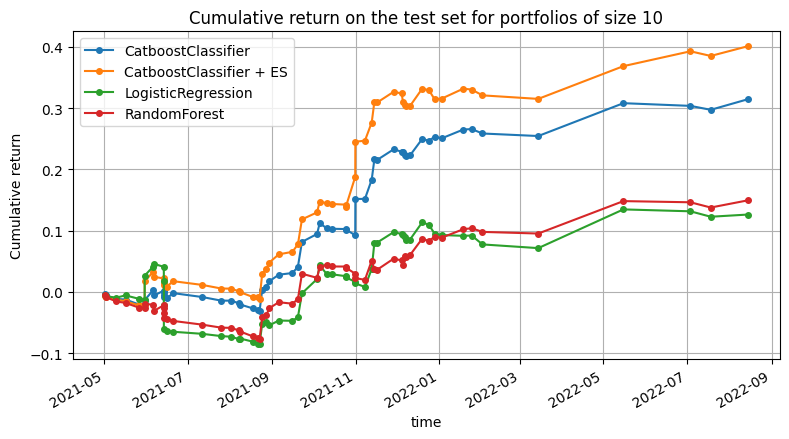

In [318]:
fig = plt.figure(figsize=(8, 4.5))
ax = fig.add_subplot(111)

for model, df_model in df_stats.groupby("model"):
    df_model["cumulative_return"] = df_model["portfolio_return"].cumsum()
    df_model.plot(x="pump_time", y="cumulative_return", ax=ax, label=model, legend=False, marker="o", markersize=4)

plt.title("Cumulative return on the test set for portfolios of size 10")
plt.ylabel("Cumulative return")
plt.xlabel("time")
plt.legend()
plt.tight_layout()

plt.grid(True)
plt.savefig("portfolios_test.png", dpi=300)
plt.show()

In [139]:
sharpe_stats = {}

for model, df_group in df_stats.groupby("model"):
    sharpe_ratio = df_group["portfolio_return"].mean() * 365 / (df_group["portfolio_return"].std() * np.sqrt(365))
    sharpe_stats[model] = sharpe_ratio

sharpe_stats

{'CatBoostClassifier Tuned': 4.325569304334807,
 'CatBoostClassifier Tuned + TOPKAUC EarlyStopping': 6.936028810665783,
 'EnsembledModel': 5.641456684345639,
 'LogisticRegression Tuned': 4.177322337148198,
 'RandomForestClassifier Tuned': 2.9839133090236993}

In [325]:
# Performance of the best model on the test sample

df_best_stats = pd.DataFrame()

for K in [1, 3, 5, 10, 20, 30]:
    manager = TOPKPortfolio(model=model_cb_custom, use_k=K)
    df_returns: pd.DataFrame = manager.backtest(df_test=df_test, reg_cols=reg_cols)
    df_returns["Portfolio size K"] = K
    df_best_stats = pd.concat([df_best_stats, df_returns])

100%|██████████| 60/60 [00:13<00:00,  4.30it/s]


In [331]:
print(
    df_best_stats.groupby("Portfolio size K")["portfolio_return"].agg(
        ["min", "mean", "median", "std", "max"]
    ).round(4).to_latex()
)

\begin{tabular}{lrrrrr}
\toprule
 & min & mean & median & std & max \\
Portfolio size K &  &  &  &  &  \\
\midrule
1 & -0.037400 & 0.001800 & -0.002500 & 0.021900 & 0.109000 \\
3 & -0.020200 & 0.009900 & -0.002400 & 0.040100 & 0.215100 \\
5 & -0.022500 & 0.011000 & -0.001300 & 0.030200 & 0.124500 \\
10 & -0.014700 & 0.006700 & -0.001200 & 0.017100 & 0.057300 \\
20 & -0.008000 & 0.002300 & -0.001200 & 0.008700 & 0.034100 \\
30 & -0.015400 & 0.000800 & -0.001100 & 0.006400 & 0.020500 \\
\bottomrule
\end{tabular}



<h4>Feature importances</h4>

In [ ]:
import shap

# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X=df_test[reg_cols], y=df_test["is_pumped"])


# Summary plot of SHAP values for all instances
shap.summary_plot(shap_values, X_test)

In [380]:
feature_importances = model_cb_custom.get_feature_importance(data=ptrain, type="LossFunctionChange")

df_cb_fi = pd.DataFrame({
    "feature": model_cb_custom.feature_names_,
    "feature_importance": model_cb_custom.feature_importances_
}).sort_values(by="feature_importance", ascending=False)

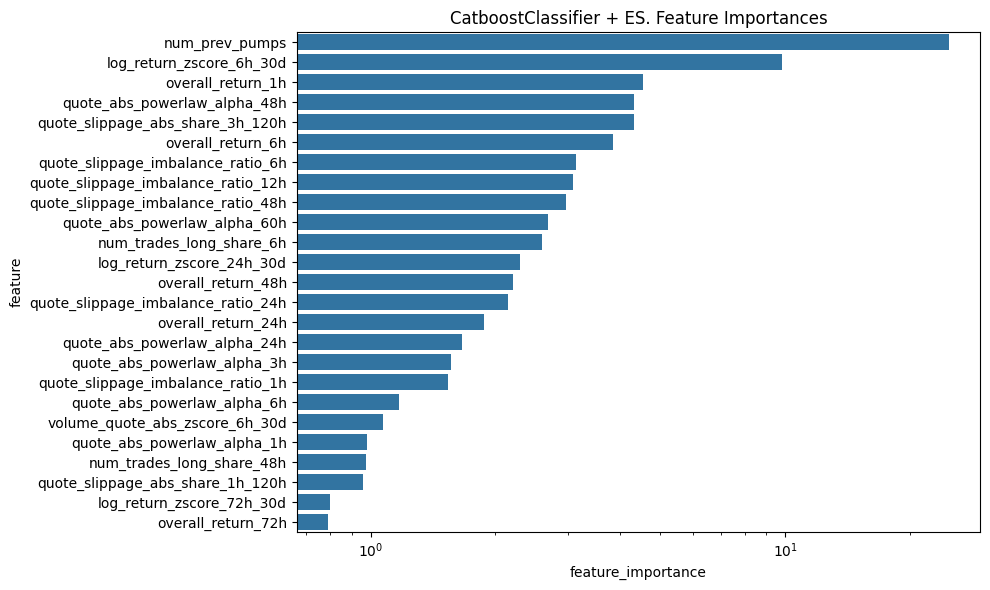

In [390]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

sns.barplot(
    data=df_cb_fi.iloc[:25],
    x="feature_importance",
    y="feature",
    ax=ax,
)
ax.set_xscale("log")

plt.title("CatboostClassifier + ES. Feature Importances")

plt.tight_layout()

plt.savefig("catboost_fi.png", dpi=300)
plt.show()

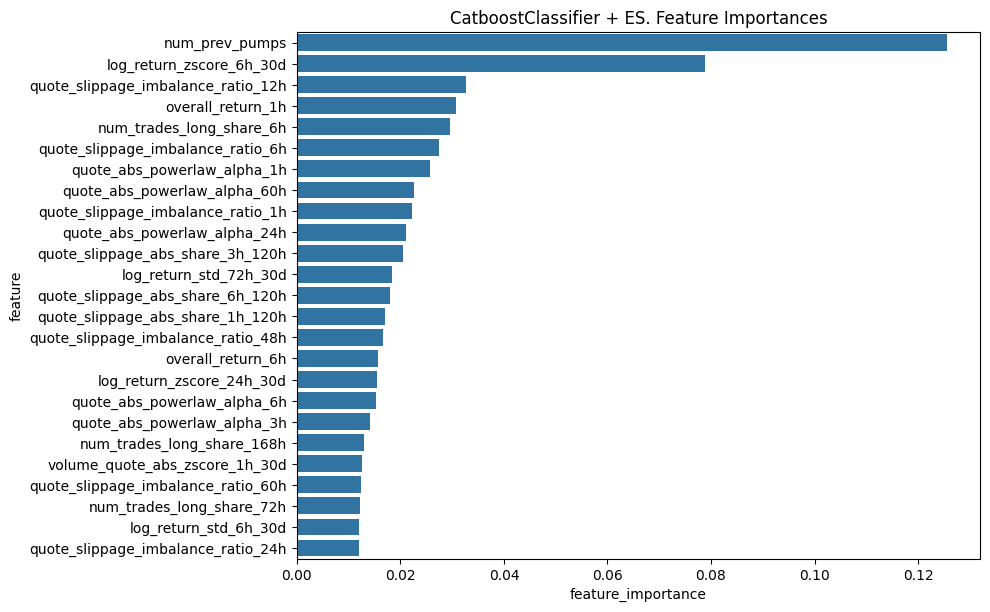

In [384]:
df_rf_fi = pd.DataFrame(
    {"feature": model_rf.feature_names_in_, "feature_importance": model_rf.feature_importances_}
).sort_values(by="feature_importance", ascending=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

sns.barplot(
    data=df_rf_fi.iloc[:25],
    x="feature_importance",
    y="feature",
    ax=ax,
)

plt.tight_layout()
plt.title("CatboostClassifier + ES. Feature Importances")
plt.show()